# MONTAR DRIVE

In [259]:
#Montar el drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORTAR LIBRERIAS

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal
from scipy import fftpack
from importlib import reload
from scipy import stats

#PARA LAS SEÑALES DE MATLAB
import scipy.io as sio

#KMEANS
from sklearn.cluster import KMeans

#KNN
from sklearn.neighbors import KNeighborsClassifier

# CARGAR SEÑALES .mat

In [ ]:
#crea un diccionario con los datos de la estructura de matlab. Con los mismos nombres
def cargar_datosxpac(filename):
  struct = sio.loadmat(filename)
  datos_xpac = {}
  for i in range(0,len(struct['Pts'][0].dtype.names)):
    datos_xpac[struct['Pts'][0].dtype.names[i]] = struct['Pts'][0][0][i]
  return datos_xpac

In [ ]:
def cargar_listas(dI,dII,v1,v2,v3,v4,v5,v6,fm,R,T,QRS_on,QRS_end,T_on,T_end,labels):
  for i in range(1,46):
    path = '/content/drive/MyDrive/PSB - FINAL/Señales/pac'+str(i)+'.mat'
    pac = cargar_datosxpac(path)
    #derivaciones
    dI.append(pac['ECG'][:,0].tolist())
    dII.append(pac['ECG'][:,1].tolist())
    v1.append(pac['ECG'][:,2].tolist())
    v2.append(pac['ECG'][:,3].tolist())
    v3.append(pac['ECG'][:,4].tolist())
    v4.append(pac['ECG'][:,5].tolist())
    v5.append(pac['ECG'][:,6].tolist())
    v6.append(pac['ECG'][:,7].tolist())
    fm.append(pac['fm'][0][0])
    labels.append(pac['labels'][0][0])

    #puntos fiduciales
    
    for j in range(0,len(pac['fiduciales'][0][0])): #cantidad campos que tiene la estructura
      for l in range(0,len(pac['fiduciales'][0][0][j].tolist())): # cantidad de puntos para ese campo
        if j == 0:
          R[i-1].append(pac['fiduciales'][0][0][j].tolist()[l][0])
        if j == 1:
          T[i-1].append(pac['fiduciales'][0][0][j].tolist()[l][0])
        if j == 2:
          QRS_on[i-1].append(pac['fiduciales'][0][0][j].tolist()[l][0])
        if j == 3:
          QRS_end[i-1].append(pac['fiduciales'][0][0][j].tolist()[l][0])
        if j == 4:
          T_on[i-1].append(pac['fiduciales'][0][0][j].tolist()[l][0])
        if j == 5:
          T_end[i-1].append(pac['fiduciales'][0][0][j].tolist()[l][0])

In [ ]:
#Incialización de las listas. Todas con longitud 45 (nro de pacientes)

dI = []
dII = []
v1 = []
v2 = []
v3 = []
v4 = []
v5 = []
v6 = []
fm = []
R = [[] for x in range(int(45))]
T = [[] for x in range(int(45))]
QRS_on = [[] for x in range(int(45))]
QRS_end = [[] for x in range(int(45))]
T_on = [[] for x in range(int(45))]
T_end = [[] for x in range(int(45))]
labels = []

#completar listas con los datos
cargar_listas(dI,dII,v1,v2,v3,v4,v5,v6,fm,R,T,QRS_on,QRS_end,T_on,T_end,labels)

# se tienen las listas dI,dII,v1,v2,v3,v4,v5,v6,fm,R,T,QRS_on,QRS_end,T_on,T_end 
# completas con los datos de cada paciente.

# FUNCIONES PARA GRAFICAR

## Señales de ECG. Todas las derviaciones por paciente

In [ ]:
#Graficar todas las derivaciones de un paciente en particular
def graficar_ECG(pac_nro):
  #pac_nro es el número de la posición de los arreglo
  fig, axs = plt.subplots(4, 2,figsize=(50,20))
  fig.suptitle('8 derivaciones del PAC'+str(pac_nro+1))
  axs[0,0].plot(np.arange(0,len(dI[pac_nro])*1/fm[pac_nro],1/fm[pac_nro]),dI[pac_nro])
  axs[0,0].set_title('DI')
  axs[0,1].plot(np.arange(0,len(dII[pac_nro])*1/fm[pac_nro],1/fm[pac_nro]),dII[pac_nro])
  axs[0,1].set_title('DII')
  axs[1,0].plot(np.arange(0,len(v1[pac_nro])*1/fm[pac_nro],1/fm[pac_nro]),v1[pac_nro])
  axs[1,0].set_title('V1')
  axs[1,1].plot(np.arange(0,len(v2[pac_nro])*1/fm[pac_nro],1/fm[pac_nro]),v2[pac_nro])
  axs[1,1].set_title('V2')
  axs[2,0].plot(np.arange(0,len(v3[pac_nro])*1/fm[pac_nro],1/fm[pac_nro]),v3[pac_nro])
  axs[2,0].set_title('V3')
  axs[2,1].plot(np.arange(0,len(v4[pac_nro])*1/fm[pac_nro],1/fm[pac_nro]),v4[pac_nro])
  axs[2,1].set_title('V4')
  axs[3,0].plot(np.arange(0,len(v5[pac_nro])*1/fm[pac_nro],1/fm[pac_nro]),v5[pac_nro])
  axs[3,0].set_title('V5')
  axs[3,1].plot(np.arange(0,len(v6[pac_nro])*1/fm[pac_nro],1/fm[pac_nro]),v6[pac_nro])
  axs[3,1].set_title('V6')

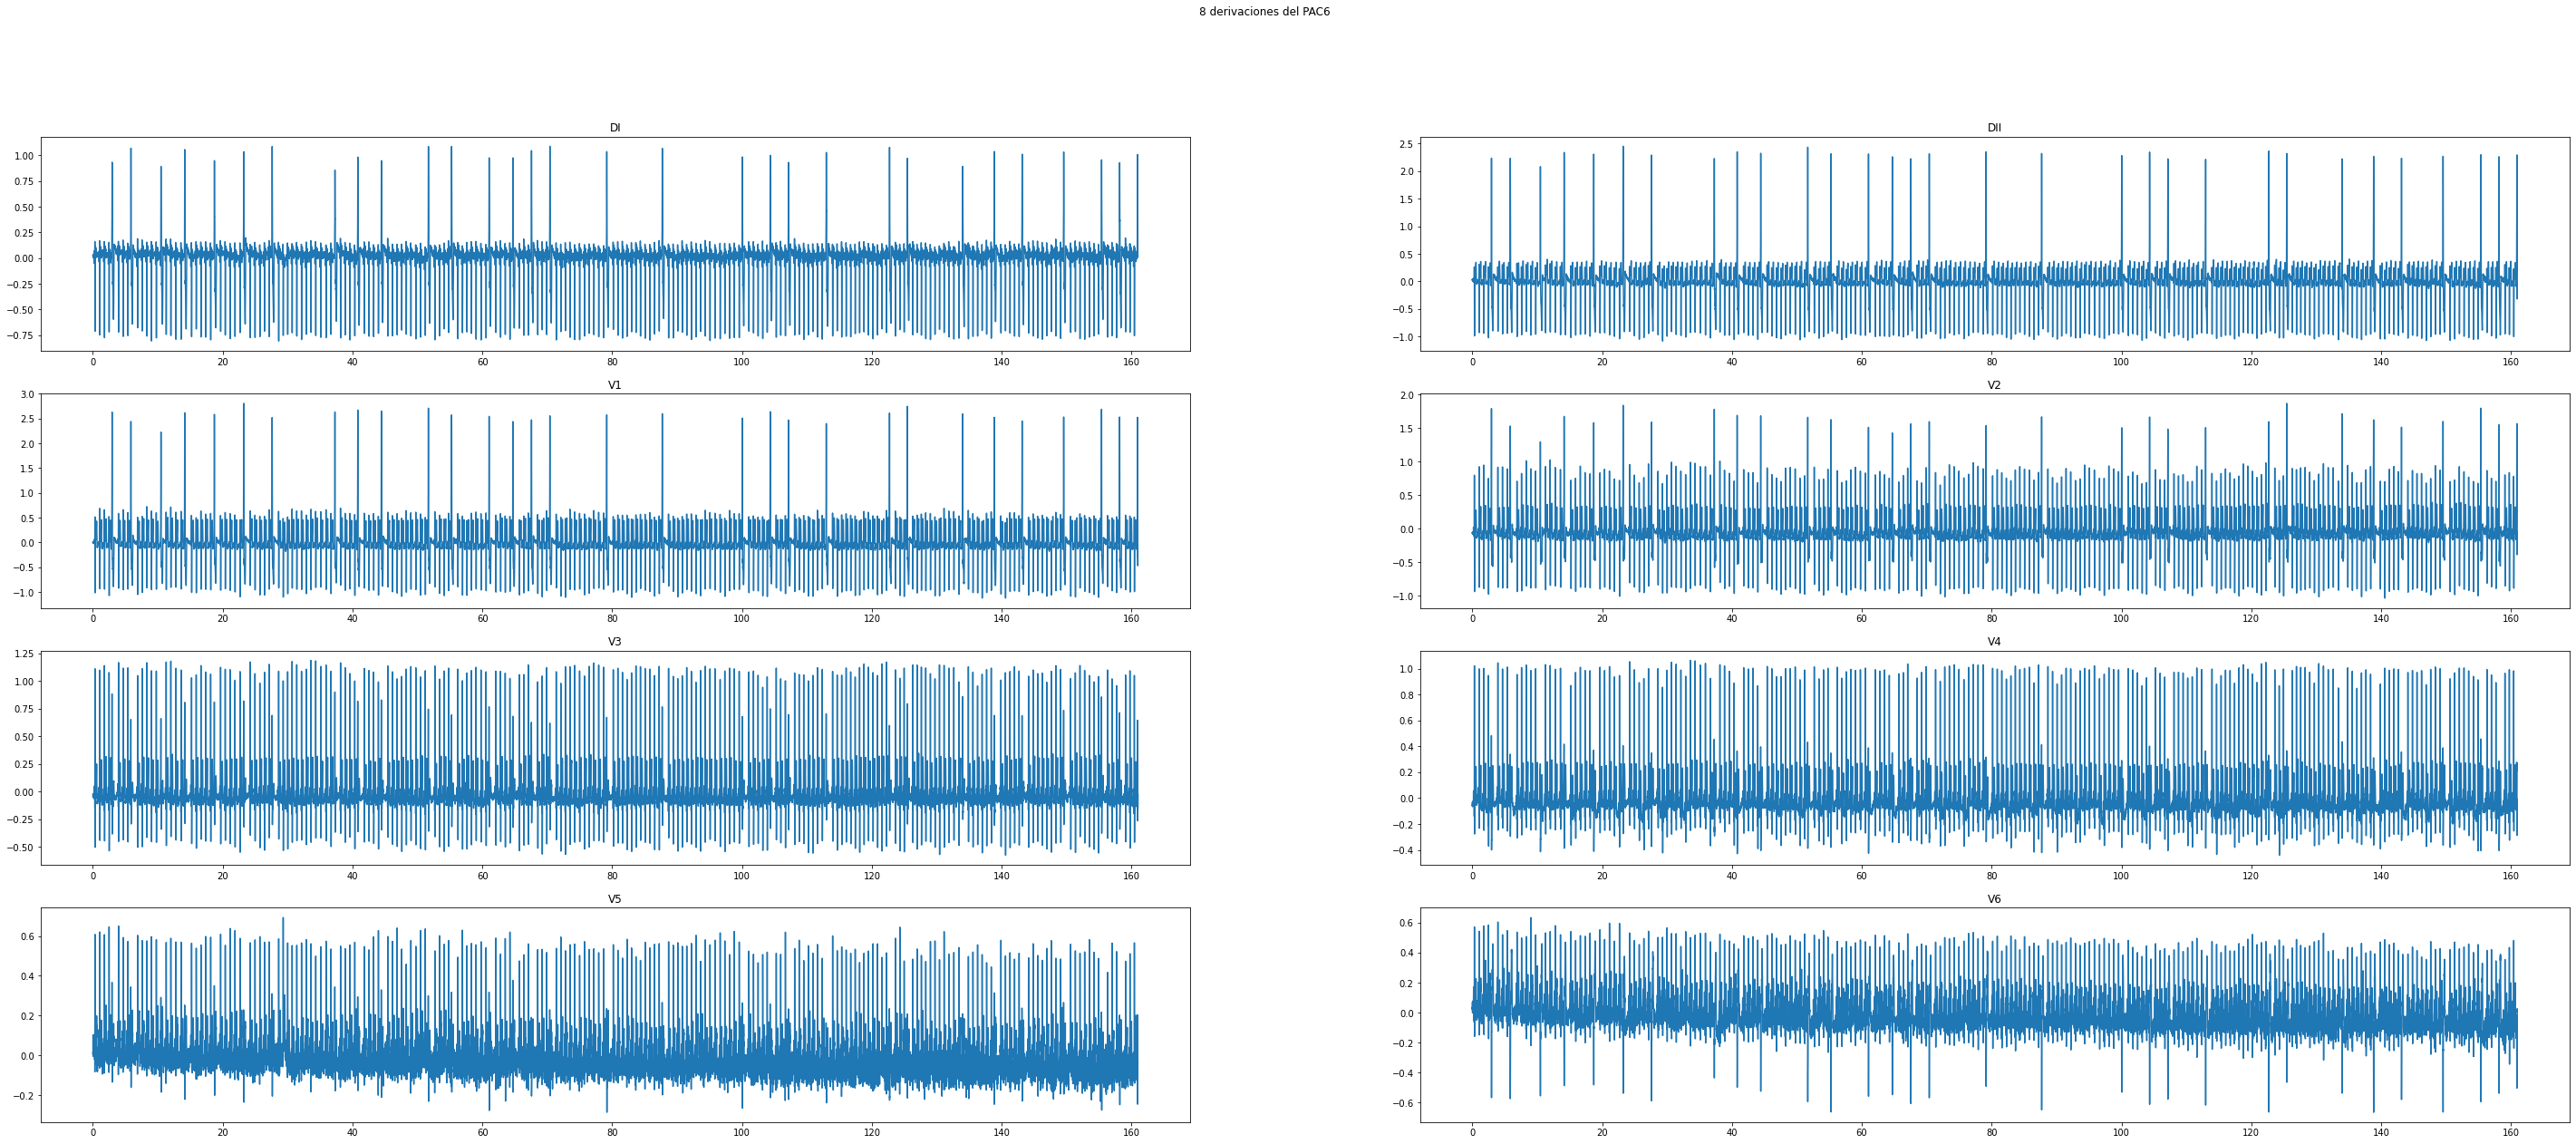

In [ ]:
graficar_ECG(5)

## Respuesta en Frecuencia y Diagrama de polos y ceros de un Filtro

In [ ]:
def graficar_rtaFiltos(b,a,fm,freqlim,amplim):
  w, h = signal.freqz(b,a,worN=1000,fs=fm)

  widths = [700, 700]
  heights = [5, 5]
  fig2 = plt.figure(constrained_layout=True)
  gs = fig2.add_gridspec(2, 2, width_ratios=widths, height_ratios=heights)

  f2_ax1 = fig2.add_subplot(gs[0, 0])
  f2_ax2 = fig2.add_subplot(gs[1,0])
  f2_ax3 = fig2.add_subplot(gs[:,1])

  f2_ax1.plot(w,20 * np.log10(abs(h)))
  f2_ax1.set_ylabel('Módulo [dB]')
  f2_ax1.set_xlabel('Frequencia [Hz]')
  f2_ax1.grid(True)
  f2_ax1.set_ylim(amplim)
  f2_ax1.set_xlim(freqlim)

  f2_ax2.plot(w,np.angle(h)*np.pi/180)
  f2_ax2.set_ylabel('Fase')
  f2_ax2.set_xlabel('Frequencia [Hz]')
  f2_ax2.set_xlim(freqlim)
  f2_ax2.grid(True)

  z,p,k = signal.tf2zpk(b,a)
  uc = matplotlib.patches.Circle((0,0), radius=1, fill=False, color='black', ls='dashed')
  f2_ax3.add_patch(uc)
  f2_ax3.set_title('Diagrama de Polos y Ceros')
  f2_ax3.scatter(np.real(p),np.imag(p), marker="x",c='blue')
  f2_ax3.scatter(np.real(z),np.imag(z),marker="o",c='blue')
  f2_ax3.grid(True)
  r = 1.5; f2_ax3.axis('auto'); f2_ax3.axis([-r, r, -r, r])


/usr/local/lib/python3.6/dist-packages/scipy/signal/filter_design.py:470: RuntimeWarning: invalid value encountered in true_divide
  npp_polyval(zm1, a, tensor=False))


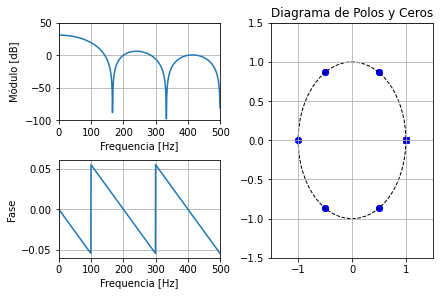

In [ ]:
graficar_rtaFiltos([1,0,0,0,0,0,-2,0,0,0,0,0,1],[1,-2,1],1000,[0,500],[-100,50])

## Transformada de fourier

In [ ]:
def graficar_fft(data,fs,freqlim):
  # ------- PARAMETROS -------
  #data : señal sobre la que se aplica la fft
  #fs: frecuencia de muestreo
  #freqlim: frecuencias mímina y máxima que se grafica

  datafft = np.fft.fftshift(np.fft.fft(data))
  freq = np.arange((-1)*fs/2,fs/2,fs/len(data))
  plt.plot(freq,abs(datafft))
  plt.xlim(freqlim)
  plt.grid(True)
  plt.xlabel('frecuencia [Hz]')
  plt.title('Transformada de Fourier')

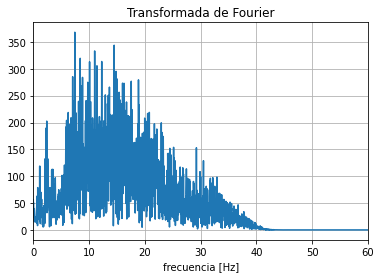

In [ ]:
graficar_fft(v6[10],fm[0],[0,60])

# FUNCIONES PARA CREAR LOS FILTROS

## Promedio Movil


In [ ]:
  def promedio_movil(orden):
    #------- PARAMETROS ------- 
    #rta_frec: 1 para graficar la respuesta en frecuencia del filtro
    # ------ SALIDA -------
    # coeficientes b y a del filtro

    b = (1/orden)*np.ones(orden)
    a = np.array([1])
    a = np.insert(a,1,np.zeros(orden-1)) 

    return b,a

In [ ]:
b,a = promedio_movil(6)

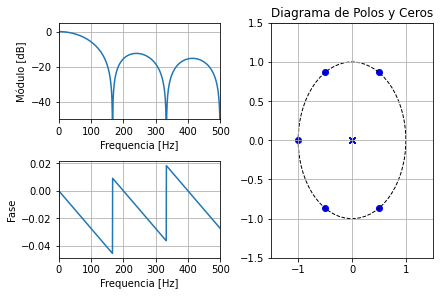

In [ ]:
graficar_rtaFiltos(b,a,fm[0],[0,500],[-50,5])

## FIR. Pasa-banda

In [ ]:
# ------ COEFICIENTES a para FIR -------
#a = np.array([1])
#a = np.insert(a,1,np.zeros(n-1)) 

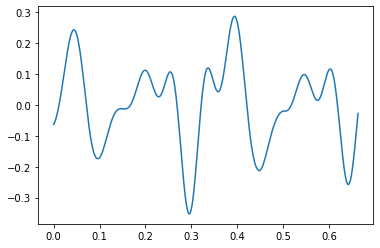

In [ ]:
struct = sio.loadmat('/content/drive/MyDrive/PSB - FINAL/FIR402.mat')
b = struct['Num'][0]
pac_nro = 4
filtrada = np.convolve(b,dII[pac_nro],'same')
plt.plot(np.arange(0,len(dII[pac_nro])*1/fm[pac_nro],1/fm[pac_nro]),filtrada)


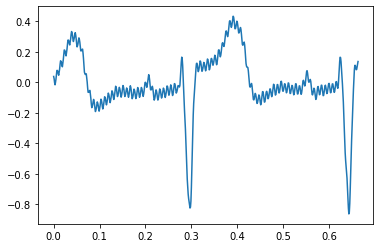

In [ ]:
plt.plot(np.arange(0,len(dII[pac_nro])*1/fm[pac_nro],1/fm[pac_nro]),dII[pac_nro])

## Derivativo

In [ ]:
def derivarivo_filtro(sf,fs):
  b = np.array([1,-1])/(2*sf/fs)
  b = np.insert(b,1,np.zeros(2*sf+1))
  return b

# PAN Y TOMKPINS

In [ ]:
def pan_tompkins(pac_nro,derivacion,graficar):

  fs = fm[pac_nro]
  if derivacion == 'DI':
    signal = dI[pac_nro]
  elif derivacion == 'DII':
    signal = dII[pac_nro]
  elif derivacion == 'V1':
    signal = v1[pac_nro] 
  elif derivacion == 'V2':
    signal = v2[pac_nro]
  elif derivacion == 'V3':
    signal = v3[pac_nro]   
  elif derivacion == 'V4':
    signal = v4[pac_nro] 
  elif derivacion == 'V5':
    signal = v5[pac_nro]
  elif derivacion == 'V6':
    signal = v6[pac_nro]
  else:
    print('El parametro derivacion debe ser: DI, DII, V1, V2, V3, V4, V5, V6')

  tiempo = np.arange(0,len(signal)*1/fs,1/fs)
  
  # FIR. PASA-BANDA
  struct = sio.loadmat('/content/drive/MyDrive/PSB - FINAL/FIR402.mat') #filtro de Matlab
  bPB = struct['Num'][0]
  filtradaPB = np.convolve(bPB,signal,'same')

  #DERIVATIVO. Uso función 
  sf = 20
  bD = derivarivo_filtro(sf,fs)
  filtradaD = np.convolve(filtradaPB, bD, 'same')

  #CUADRADO
  filtradaC = np.square(filtradaD)

  #PROMEDIO MOVIL
  bPM,aPM = promedio_movil(50)
  filtradaPM = np.convolve(filtradaC, bPM, 'same')

  if graficar == 'true':
    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6, 1,figsize=(50,20))

    #grafico señal original
    ax1.plot(tiempo,signal)
    ax1.set_ylabel('ECG')

    #grafico señal filtrada por FIR pasabanda
    ax2.plot(tiempo,filtradaPB)
    ax2.set_ylabel('FIR - PB')

    #grafico señal filtrada con derivativo
    ax3.plot(tiempo,filtradaD)
    ax3.set_ylabel('Derivada')

    #grafico señal filtrada con derivativo al cuadrado
    ax4.plot(tiempo,filtradaC)
    ax4.set_ylabel('Derivada^2')

    #grafico señal filtrada con promedio movil
    ax5.plot(tiempo,filtradaPM)
    ax5.set_ylabel('Promeido Movil')

    #grafico con tiempo de referencia de 20s
    ax6.plot(tiempo,filtradaPM)
    ax6.set_xlim([0,20])
    ax6.set_xlabel('Tiempo [s]')

  elif graficar != 'false':
    print("El parametro graficar debe ser true or false")

  #------SALIDA------
  #Genero estructura con tiempo y la señal filtrada con promedio movil
  resultado = []
  resultado.append(tiempo)
  resultado.append(signal)
  resultado.append(filtradaPM)

  return resultado

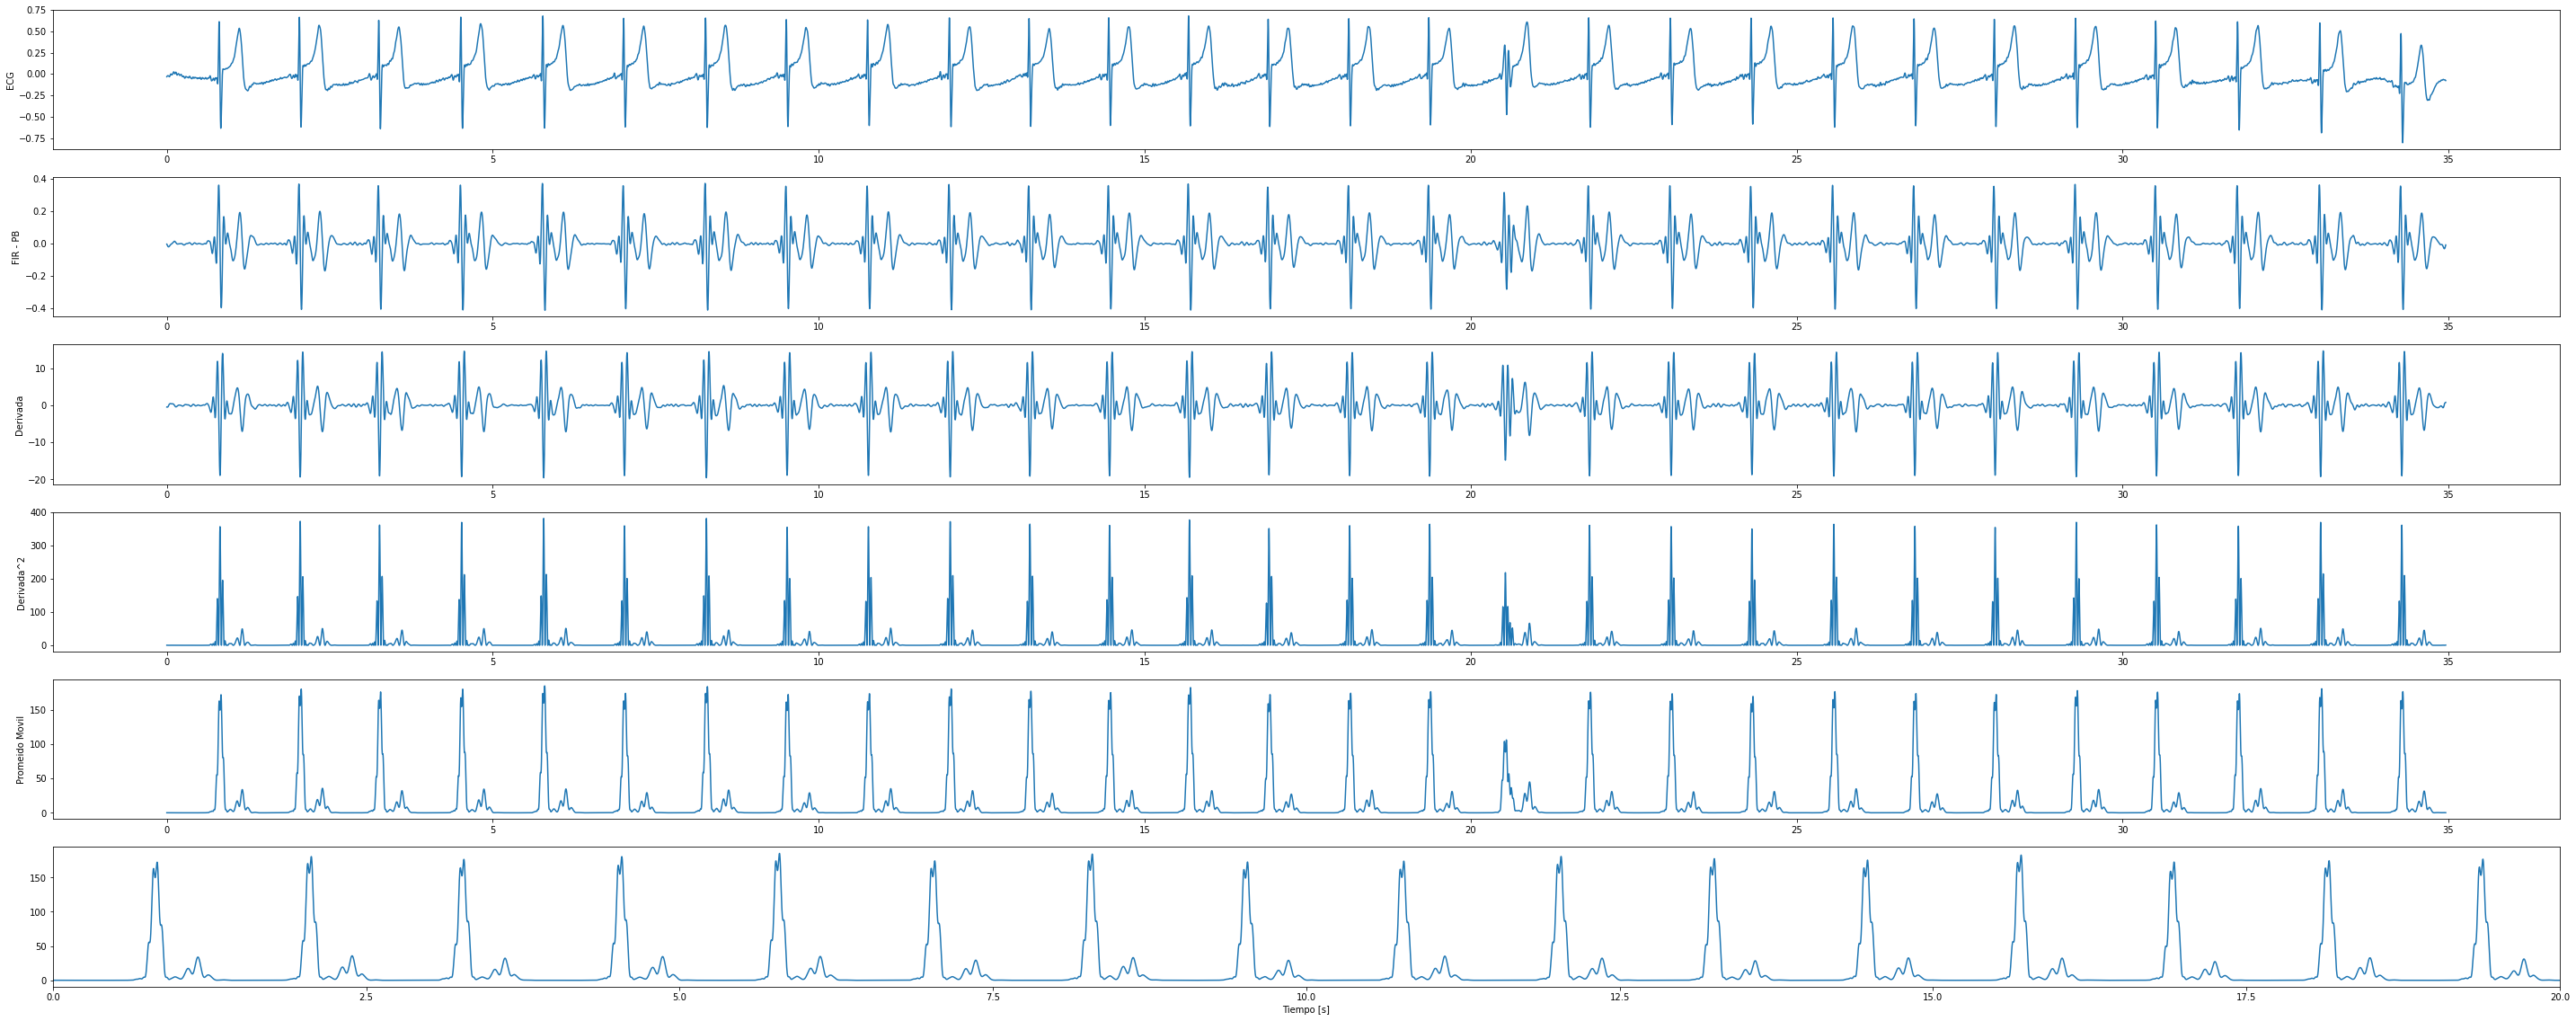

In [ ]:
[t,s,filtrada] = pan_tompkins(30,'DII','true')

# ALGORITMO DE DETECCIÓN DEL QRS

Detección de picos de la señal filtrada

In [ ]:
 def picos_senal(filtradaPM,tiempo_vector,graficar):
  picos = signal.find_peaks(filtradaPM,distance=0.4*1000) # tomamos 0.4, buscamos duracion normal de QRS
  #picos = signal.find_peaks(filtradaPM,0.1*1000)

  if graficar == 1:
    plt.figure(figsize=[20,7])
    plt.scatter(tiempo_vector[picos[0]],filtradaPM[picos[0]],c='red')
    plt.plot(tiempo_vector,filtradaPM)
    m = np.ones(len(filtradaPM))
    m2 = np.mean(filtradaPM[picos[0]])*np.ones(len(filtradaPM))
    plt.plot(tiempo_vector,m2)
    #plt.xlim([21,22])

  #----- SALIDA ------ 
  #el vector de las posiciones de los picos de la señal
  #el valor de la media de las amplitudes de los picos en la señal filtrada

  media = np.mean(filtradaPM[picos[0]])
  picos = picos[0]
  return picos,media

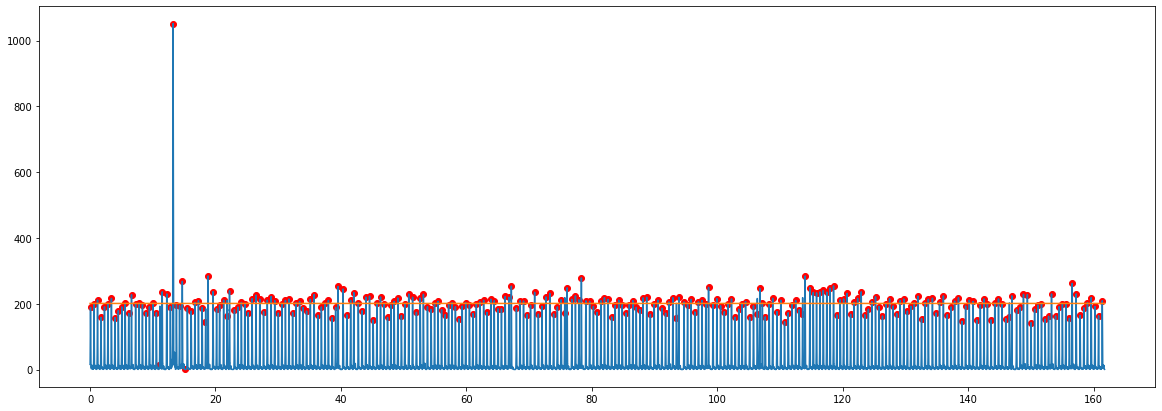

In [ ]:
[t,s,filtrada] = pan_tompkins(20,'DII','false')
p,media = picos_senal(filtrada,t,1)

HISTOGRAMA

Analisis estadístico de los picos de la señal

In [ ]:
#HISTOGRAMA DE LOS PICOS DE LA SEÑAL FILTRADA CON PAN Y TOMPKINS
#Normaliza la señal filtrada y elegimos un número fijo de cajas 

def hist_picos(filtrada,p,nro_intervalos,graficar):

  norma = filtrada/np.max(filtrada)
  hist, bin_edges = np.histogram(norma[p],bins=nro_intervalos)

  if graficar == 1:
    plt.figure()
    plt.hist(filtrada[p],bins = nro_intervalos)
    plt.axvline(np.mean(filtrada[p]), color='red', linestyle='dashed', linewidth=1)

  #----- SALIDA -----
  #hist = frecuencias de aparicion en cada intervalo
  #bin_edges = limites de cada intervalo -> señal normalizada

  return hist,bin_edges

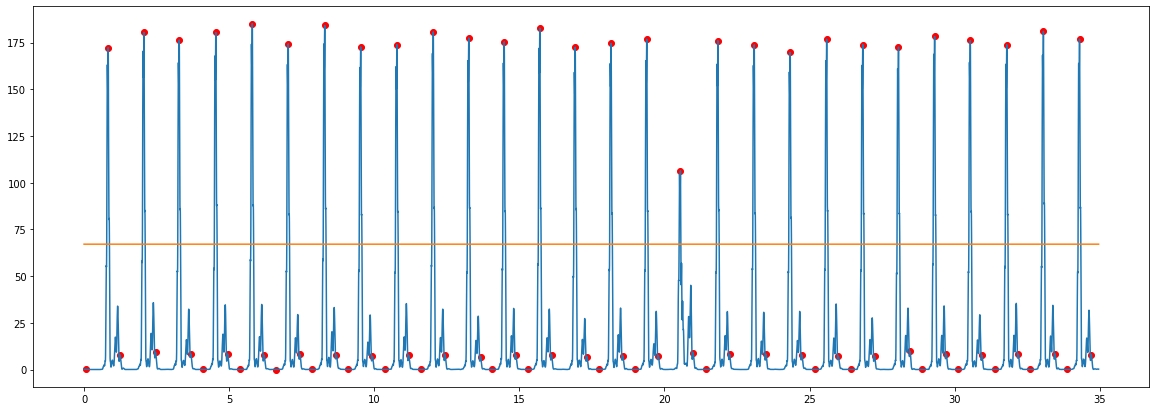

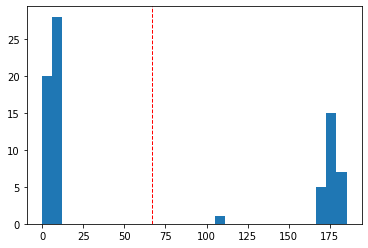

In [ ]:
[t,s,filtrada] = pan_tompkins(30,'DII','false')
p,media = picos_senal(filtrada,t,1)
nro_intervalos = 30 #en el paciente 3 puede haber problema usando este nro_intervalo
hist,limites_norm = hist_picos(filtrada,p,nro_intervalos,1)

In [ ]:
#primero ver donde se encuentra el pico más bajo de la señal ()

def clasif_picos(filtradaPT,t,media,hist,bin_edges,picos,graficar):
  #picos es un array
  #filtradaPT es un array
  umbral1 = 0.4
  umbral2 = 0.4
 
  max_senal = np.max(filtradaPT)
  media_norm = media/max_senal
  media_norm = media/max_senal
  caja1_ext = bin_edges[1]
  if caja1_ext > umbral1*media_norm: # asumimos que no hay nube de picos bajos 
    #todos los picos detectados por findpeaks son QRS
    qrs = picos
  else:
    for i in range(1,len(hist)): 
      if hist[i] != 0:
        if ((bin_edges[i]+bin_edges[i+1])/2) > umbral2*media_norm:
              qrs_aux = np.where(filtradaPT[picos] > umbral2*media)
              qrs = picos[qrs_aux]
              break
  
  if graficar == 1:
    plt.figure()
    plt.plot(t,filtradaPT)
    plt.scatter(t[qrs],filtradaPT[qrs],c = 'red')
    #plt.xlim([0,1])

  #qrs: array con las posiciones 
  return qrs

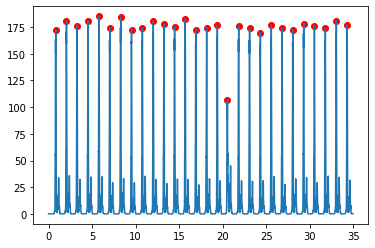

In [ ]:
qrs = clasif_picos(filtrada,t,media,hist,limites_norm,p,1)

In [ ]:
def clasif2_picos(filtradaPT,t,media,picos,graficar):
  #picos es un array
  #filtradaPT es un array
  umbral1 = 0.4
  umbral2 = 0.4
  max_senal = np.max(filtradaPT)
  media_norm = media/max_senal

  if np.min(filtradaPT[picos]) > umbral1*media: # asumimos que no hay nube de picos bajos 
    #todos los picos detectados por findpeaks son QRS
    qrs = picos
  else:
    qrs_aux = np.where(filtradaPT[picos] > umbral2*media)
    qrs = picos[qrs_aux]

  if graficar == 1:
    plt.figure()
    plt.plot(t,filtradaPT)
    plt.scatter(t[qrs],filtradaPT[qrs],c = 'red')
    #plt.xlim([20,25])

  #qrs: array con las posiciones 
  return qrs

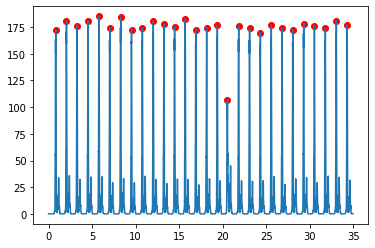

In [ ]:
qrs = clasif2_picos(filtrada,t,media,p,1)

# DETECTAR QRS

In [ ]:
def deteccion_qrs(pac_nro,derivacion,graficar,lim_tiempo):
  [t,ss,filtradaPT] = pan_tompkins(pac_nro,derivacion,'false')
  [p,media] = picos_senal(filtradaPT,t,0)
  qrs = clasif2_picos(filtradaPT,t,media,p,0)

  s_array = np.array(ss)
  s6_array = np.array(v6[pac_nro])

  if graficar == 1:
    fig, (ax1,ax2,ax3) = plt.subplots(3, 1,figsize=(50,20),sharex=True)
    ax1.plot(t,s_array)
    ax1.scatter(t[qrs],s_array[qrs],c = 'red')
    ax1.set_title('Señal Original DII')
    #ax1.set_xlim([0,5])

    ax2.plot(t,filtradaPT)
    ax2.scatter(t[qrs],filtradaPT[qrs],c = 'red')
    ax2.set_title('Señal Pan y Tompkins')
    #ax2.set_xlim([0,5])

    ax3.plot(t,s6_array)
    ax3.scatter(t[qrs],s6_array[qrs],c = 'red')
    ax3.set_title('Señal V6')
    #ax3.set_xlim([0,5])
    plt.tight_layout()
    plt.xlim(lim_tiempo)


  resultado = []
  resultado.append(t)
  resultado.append(s_array)
  resultado.append(qrs)

  return resultado

# GENERAR LISTA CON LOS QRS DE TODOS LOS PACIENTES EN DII

In [ ]:
def qrs_lista(derivacion):
  #deriv es la lista
  total_pacientes = 45
  QRS = []
  for i in range(0,total_pacientes):
    [t,s,x] = deteccion_qrs(i,derivacion,0,[0,1]) 
    QRS.append(x)
  return QRS

In [ ]:
QRS = qrs_lista('DII')

# Puntos fiduciales R (base de datos) en la señal original

##### Sensibilidad de qrs con puntos fiduciales de base de datos

In [ ]:
def vector_tiempo(sig,fs):
  t = np.arange(0,len(sig)*1/fs,1/fs)
  return t

In [ ]:
#sensibilidad VP/(VP+FN)
#Valor predictivo+ VP/(VP+FP)
def qrs_fiduciales(QRS,R,tol,i):
  # tol en segundos
  fs = 1000
  intervalo = int(tol*fs)/2
  latido = intervalo*10
  VP = 0
  FP = 0
  FN = 0

  #for i in range(0,45):
  if len(R[i]) >= 10:
    p = 0
    j = 0
    while (j<len(QRS[i]) and p<len(R[i])):
      valQRS = QRS[i][j]
      valR = R[i][p]
      if valQRS > (valR + latido) or valQRS < (valR - latido):
        if valQRS > valR:
          FN = FN+1
          p = p+1
          if p < len(R[i]):
            valR = R[i][p]
        else:
          FP = FP+1
          j = j+1
          if j < len(QRS[i]):
            valQRS = QRS[i][j]
      elif valQRS <= (valR + intervalo) and valQRS >= (valR - intervalo):
        VP = VP +1
        j = j+1
        p = p+1
      elif valQRS > (valR + intervalo) or valQRS < (valR - intervalo):
        FP = FP+1 
        j = j+1
        p = p+1
  
  return VP,FP,FN

In [ ]:
def sensibilidad(VP,FP,FN):
  r = VP/(VP+FN)
  return r

In [ ]:
def valPredPos(VP,FP,FN):
  r = VP/(VP+FP)
  return r

In [ ]:
[VP,FP,FN] = qrs_fiduciales(QRS,R,0.02,0)
p = valPredPos(VP,FP,FN)
s = sensibilidad(VP,FP,FN)

In [ ]:
final = np.array([0,0,0])
for i in range(0,len(QRS)):

  final = final+qrs_fiduciales(QRS,R,0.04,i)

print(final)
print(sensibilidad(final[0],final[1],final[2]))
print(valPredPos(final[0],final[1],final[2]))

[1998  318    5]
0.9975037443834248
0.8626943005181347


In [ ]:
fs=1000
pac = 6
tol = 0.01 #10 ms
intervalo = int(tol*fs)/2
print(len(QRS[pac]))
print(len(R[pac]))
print(QRS[pac])
print(R[pac])

131
130
[   226   1442   2669   3921   5191   6455   7683   9038  10320  11521
  12869  14135  14896  16564  17866  19068  20355  21572  22786  23424
  24826  26259  26938  28560  29984  31226  32428  33651  34864  36094
  37317  38554  39789  40489  41317  43116  44685  46083  47353  48658
  49930  51227  52539  53853  55154  56463  57113  58644  60215  61633
  62931  64181  65437  66688  67961  69245  70535  71850  73148  74455
  75736  77026  78279  79548  80801  82050  83317  84578  85345  87030
  88333  89178  90783  92067  92798  94434  95704  96533  98135  99315
  99986 101663 102827 103978 104484 106247 107288 108497 109672 110792
 111931 113067 114217 115372 116534 117710 118868 120076 121270 122444
 123613 124785 125912 127119 128306 129488 130682 131884 133095 134296
 135528 136757 138010 139280 140549 141815 143079 144356 145637 146932
 148231 149537 150835 152114 153394 154657 155246 156690 158009 158929
 160588]
[203, 1419, 2647, 3898, 5168, 6433, 7659, 9016, 10296, 11498

In [ ]:
for i in range(0,len(QRS)):
  if len(QRS[i]) < 10:
    print(i)

2
3
4
7
19


(0.0, 10000.0)

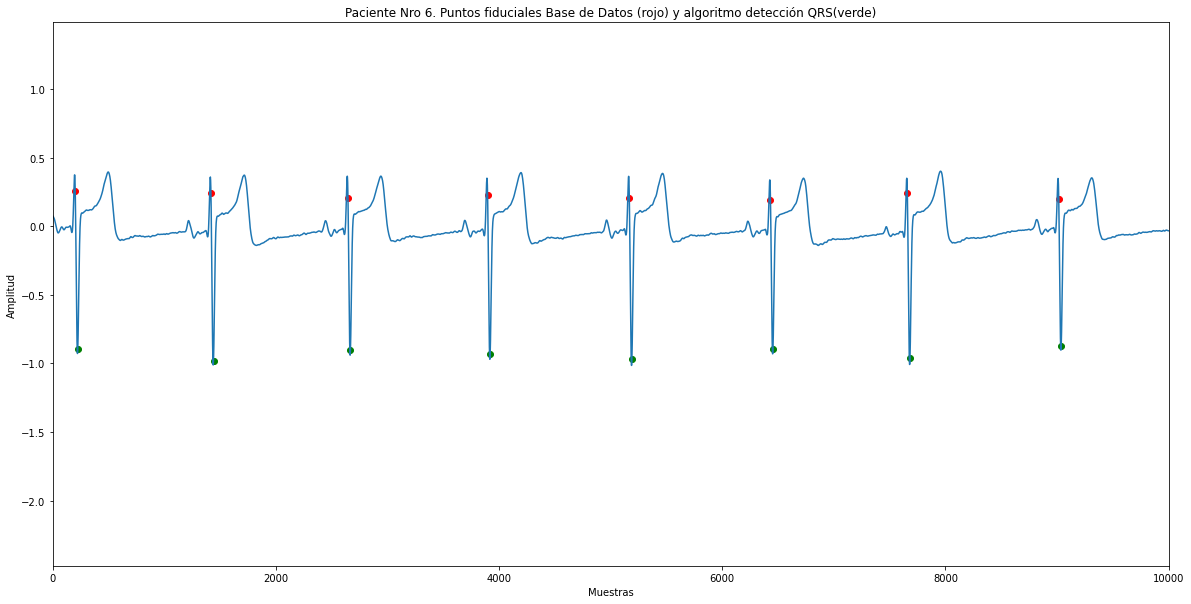

In [ ]:
nro = 6
t = vector_tiempo(dII[nro],1000)
l =[]
l_nuestra = []

for i in range(0,len(R[nro])):
  l.append(dII[nro][R[nro][i]])

for i in range(0,len(QRS[nro])):
  l_nuestra.append(dII[nro][QRS[nro][i]])

fig1, ax = plt.subplots(1,1,figsize=(20,10),sharex=True)
ax.plot(dII[nro])
ax.scatter(R[nro],l,c='red')
ax.scatter(QRS[nro],l_nuestra,c='green')
ax.set_title('Paciente Nro '+str(nro)+'. Puntos fiduciales Base de Datos (rojo) y algoritmo detección QRS(verde)')
ax.set_xlabel('Muestras')
ax.set_ylabel('Amplitud')
ax.set_xlim([0,fs*10])

#PRE-PROCESAMIENTO DE LA SEÑAL 


In [ ]:
def pre_procesamiento(pac_nro,derivacion,graficar,lim_tiempo, lim_frecuencia):
  fs = fm[pac_nro]
  if derivacion == 'DI':
    sig = dI[pac_nro]
  elif derivacion == 'DII':
    sig = dII[pac_nro]
  elif derivacion == 'V1':
    sig = v1[pac_nro] 
  elif derivacion == 'V2':
    sig = v2[pac_nro]
  elif derivacion == 'V3':
    sig = v3[pac_nro]   
  elif derivacion == 'V4':
    sig = v4[pac_nro] 
  elif derivacion == 'V5':
    sig = v5[pac_nro]
  elif derivacion == 'V6':
    sig = v6[pac_nro]
  else:
    print('El parametro derivacion debe ser: DI, DII, V1, V2, V3, V4, V5, V6')

  t = vector_tiempo(sig,fs)

  #PASA-ALTOS. fc = 0.6 Hz
  sosHP= signal.butter(50, 0.6, 'hp', fs=1000, output='sos')

  filteredHP = signal.sosfiltfilt(sosHP, sig)

  #PASA-BAJOS. fc = 42 Hz
  sosLP= signal.butter(50, 42, fs=1000, output='sos')

  filteredLP = signal.sosfiltfilt(sosLP,filteredHP)

  if graficar == 1:
    fig, (ax1, ax2,ax3) = plt.subplots(3, 1, sharex=True)
    ax1.plot(t, sig)
    ax1.set_title('Señal Original')
    ax1.axis([0, 4, -1, 1])

    ax2.plot(t, filteredHP)
    ax2.set_title('Filtrada con un Pasa Altos. Fc = 0.6 Hz')
    ax2.axis([0, 4, -1, 1])

    ax3.plot(t,filteredLP)
    ax3.set_title('Filtrada con un Pasa Bajos. Fc = 42 Hz')
    ax3.set_xlabel('Tiempo [seconds]')
    ax3.set_ylim([-1,1])
    plt.tight_layout()
    plt.xlim(lim_tiempo)
    plt.show()
    
    w, h = signal.sosfreqz(sosHP,fs=1000, whole= False)
    print()
    plt.subplot(2, 1, 1)
    plt.tight_layout()
    db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
    plt.plot(w, db)
    plt.xlim(lim_frecuencia)
    plt.ylim(-75, 5)
    plt.grid(True)
    plt.ylabel('Magnitud [dB]')
    plt.title('Respuesta en Frecuencia del filtro Pasa Altos')
    plt.subplot(2, 1, 2)
    plt.plot(w, np.angle(h))
    plt.grid(True)
    plt.ylabel('Fase [rad]')
    plt.xlabel('Frecuencia [Hz]')
    plt.show()

    w2, h2 = signal.sosfreqz(sosLP,fs=1000, whole= False)
    print()
    plt.subplot(2, 1, 1)
    plt.tight_layout()
    db2 = 20*np.log10(np.maximum(np.abs(h2), 1e-5))
    plt.plot(w2, db2)
    plt.xlim(lim_frecuencia)
    plt.ylim(-75, 5)
    plt.grid(True)
    plt.ylabel('Magnitud [dB]')
    plt.title('Respuesta en Frecuencia del filtro Pasa Bajos')
    plt.subplot(2, 1, 2)
    plt.plot(w2, np.angle(h2))
    plt.grid(True)
    plt.ylabel('Fase [rad]')
    plt.xlabel('Frecuencia [Hz]')
    plt.show()

    print()
    plt.subplot(2,1,1)
    graficar_fft(sig,fs,lim_frecuencia)
    plt.subplot(2,1,2)
    graficar_fft(filteredLP,fs,lim_frecuencia)
    plt.tight_layout()
    plt.show()

  return filteredLP


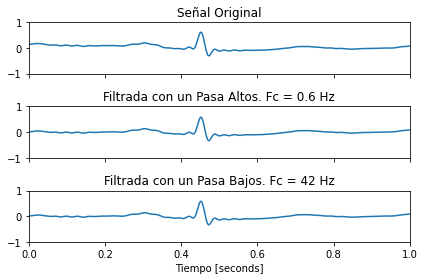

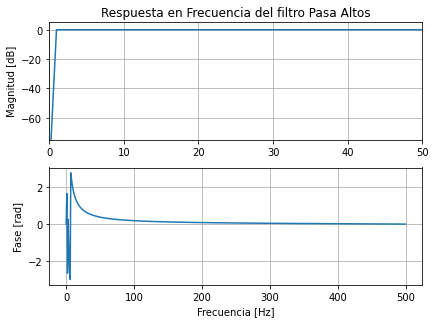

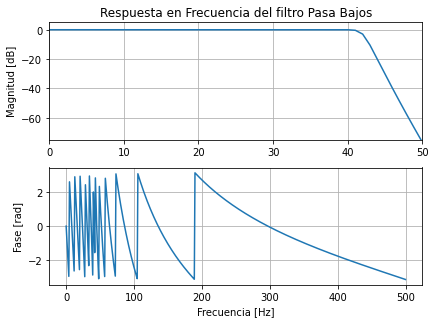

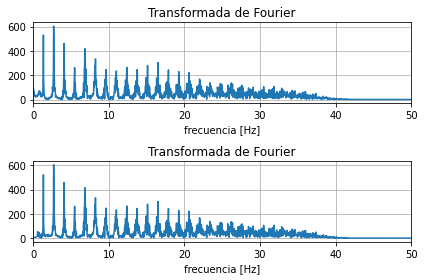

In [ ]:
filt = pre_procesamiento(16,'V6',1,[0,1],[0,50])

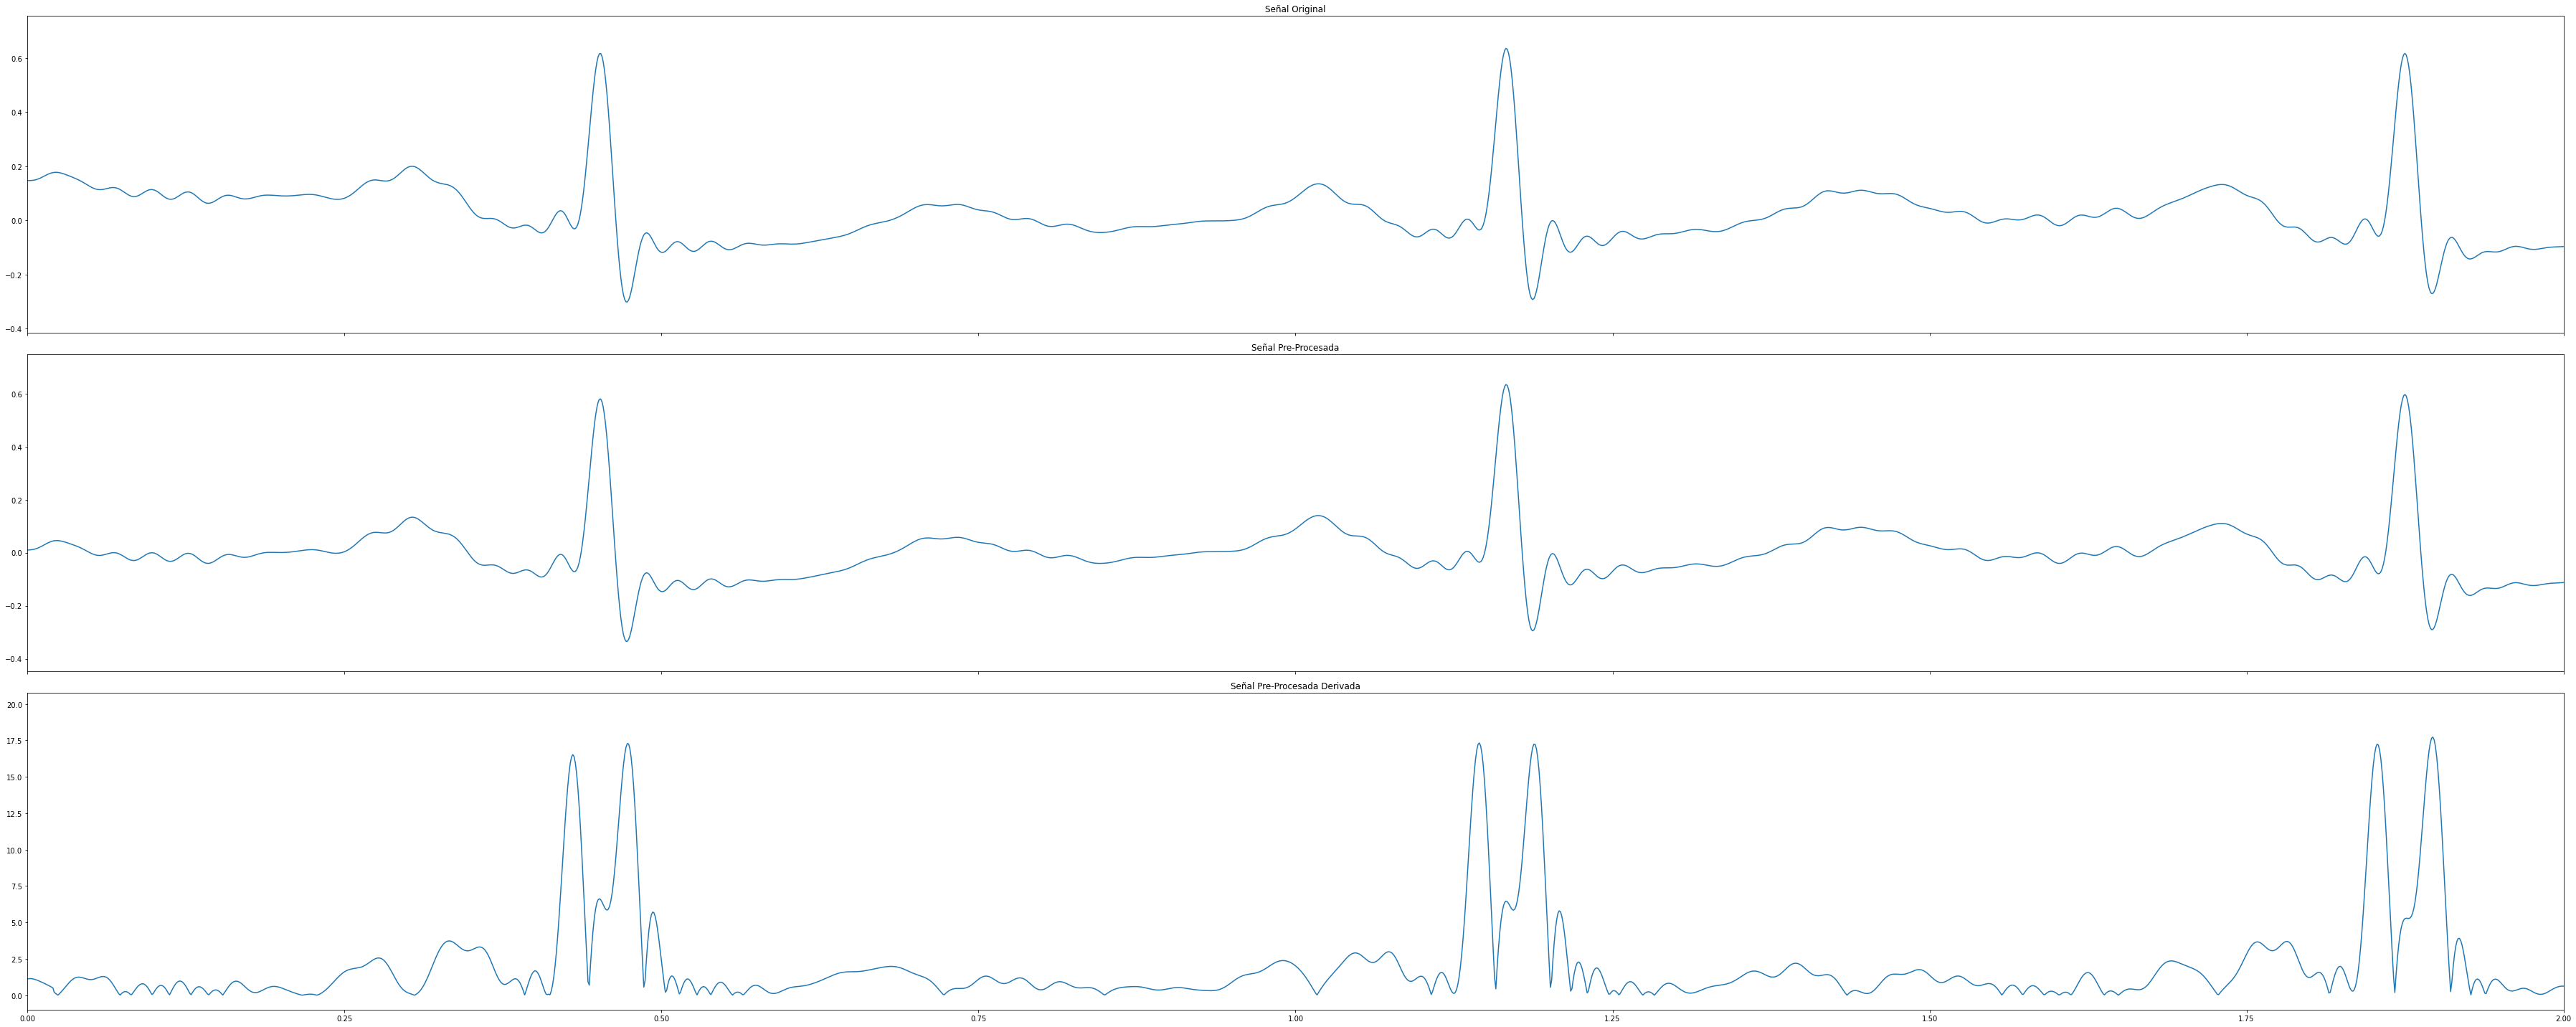

In [ ]:
nro_pac = 16
fs=1000
sf = 20
t = vector_tiempo(filt,fs)
bD = derivarivo_filtro(sf,fs)
filtradaD = np.convolve(filt, bD, 'same')
fig, (ax1,ax2,ax3) = plt.subplots(3, 1,figsize=(50,20),sharex=True)
ax2.plot(t,filt)
ax2.set_title('Señal Pre-Procesada')
ax3.plot(t,np.abs(filtradaD))
ax3.set_title('Señal Pre-Procesada Derivada')
ax1.plot(t,v6[nro_pac])
ax1.set_title('Señal Original')
plt.xlim([0,2])
plt.tight_layout()


#CARACTERISTICAS QRS

###### Detección tiempo entre pulsos

In [ ]:
def HR_nuestro(fs,s,qrs):
  #latidos por segundo
  tiempo_total = 1/fs*len(s)
  picos = len(qrs)
  r = picos/tiempo_total
  return r

##### Detección variabilidad frecuencia cardíaca

In [ ]:
def hrv(fs,s,qrs):
  tiempo = vector_tiempo(s,fs)
  rr_interval = 0

  if len(qrs) == 1:
    hr = HR_nuestro(fs,s,qrs)
    rr_interval = 1/hr
  else:
    for i in range(0,len(qrs)-1):
      rr_interval = rr_interval+tiempo[qrs[i+1]]-tiempo[qrs[i]]
    rr_interval = rr_interval/(len(qrs)-1)
  return rr_interval

In [ ]:
1/HR_nuestro(1000,v6[1],QRS[1])

0.8163265306122448

In [ ]:
hrv(1000,v6[2],QRS[2])

0.5900000000000001

##### Detección de Características de QRST 
FUNCIÓN FINAL

In [ ]:
def qrst_caract(nro_pac,graficar,lim_tiempo):
  [t,s,qrs] = deteccion_qrs(nro_pac,'DII',0,[0,1])
  filt = pre_procesamiento(nro_pac,'V6',0,[0,1],[0,100])
  fs = fm[nro_pac]

  #filtro derivador
  sf = 5
  bD = derivarivo_filtro(sf,fs)

  filtradaD = np.convolve(filt, bD, 'same')

  if graficar==1:
    fig1, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1,figsize=(50,20),sharex=True)
    fig1.suptitle('DETECCIÓN CARACTERÍSTICAS COMPLEJO QRS',fontsize=40)
    ax2.plot(t,filt)
    ax2.set_title('Señal V6 Pre-Procesada')
    ax3.plot(t,filtradaD)
    ax3.set_title('Señal V6 Pre-Procesada Derivada')
    ax1.plot(t,v6[nro_pac])
    ax1.set_title('Señal Original V6')
    plt.xlim(lim_tiempo)
    

  dur_qrs = 0.18 #duracion es entre 80 y 120 ms. Como los qrs estas corridos, tomamos una duracion alta
  intervalo = int(fs*dur_qrs/2)

  r_amp_lista = []
  penS_R_lista = []
  penB_R_lista = []
  q_amp_lista = []
  s_amp_lista = []



  t_dur = 0.32 #st interval 320 ms + 50 ms
  r_dur = 0.1
  t_intervalo = int(t_dur*fs)
  r_intervalo = int(r_dur*fs)

  sf_T = 30
  t_bD = derivarivo_filtro(sf_T,fs)
  b,a = promedio_movil(50)
  filt_prom = np.convolve(b,filt,'same')
  filtD = np.convolve(filt_prom, t_bD, 'same')

  if graficar ==1:
    fig2, (ax1_2,ax2a_2,ax2_2,ax3_2) = plt.subplots(4,1,figsize=(50,20),sharex=True)
    fig2.suptitle('DETECCIÓN CARACTERÍSTICAS ONDA T',fontsize=40)
    ax1_2.plot(t,filt)
    ax1_2.set_title('señal Pre-procesada')
    ax2a_2.plot(t,filt_prom)
    ax2a_2.set_title('señal Pre-procesada. Promedio Movil')

  penS_T_lista = []
  t_amp_lista=[]
  penB_T_lista = []

  for j in range(0,len(qrs)):
    if j == 0:
      if qrs[0]-intervalo >= 0:
        lim_inf = qrs[j]-intervalo
        lim_sup = qrs[j]+intervalo
      else:
        lim_inf = 0
        lim_sup = qrs[j]+intervalo
    elif j == len(qrs)-1:
      if qrs[len(qrs)-1]+intervalo < len(filtradaD):
        lim_inf = qrs[j]-intervalo
        lim_sup = qrs[j]+intervalo 
      else:
        lim_inf = qrs[j]-intervalo
        lim_sup = (len(filtradaD)-1)     
    else:
      lim_inf = qrs[j]-intervalo
      lim_sup = qrs[j]+intervalo
    
    der_cortada = np.abs(filtradaD[lim_inf:lim_sup])
    der_cortada_picos = signal.find_peaks(der_cortada)

    der_cortada_picos = der_cortada_picos[0]
    

    pico1 = np.sort(der_cortada[der_cortada_picos])[::-1][0]
    pico2 = np.sort(der_cortada[der_cortada_picos])[::-1][1]
    pico3 = np.sort(der_cortada[der_cortada_picos])[::-1][2]
    pico4 = np.sort(der_cortada[der_cortada_picos])[::-1][3]

    pico1_index = np.where(der_cortada == pico1)
    pico2_index = np.where(der_cortada == pico2)

    index_crec = np.sort([pico1_index[0][0],pico2_index[0][0]])

    penS_R = der_cortada[index_crec[0]]
    penB_R = der_cortada[index_crec[1]]

    penS_R_lista.append(penS_R)
    penB_R_lista.append(penB_R)

    qrs1 = filt[lim_inf:lim_sup]
    qrs1_picos = signal.find_peaks(np.abs(qrs1))

    r_amp = signal.find_peaks(np.abs(qrs1[index_crec[0]:index_crec[1]]))

    if len(r_amp[0])>1:
      r_amp = r_amp[0][int(np.round(len(r_amp[0])/2))]
      r_amp =qrs1[index_crec[0]:index_crec[1]][r_amp]
      r_amp_lista.append(r_amp)
      if graficar ==1:
        ax4.scatter(t[lim_inf:lim_sup][np.where(qrs1 == r_amp)[0][0]],r_amp,c='green')
    elif len(r_amp[0]) == 0:
      r_amp = 0
    else:
      r_amp = r_amp[0][0]
      r_amp = qrs1[index_crec[0]:index_crec[1]][r_amp]
      r_amp_lista.append(r_amp)
      if graficar ==1:
        ax4.scatter(t[lim_inf:lim_sup][np.where(qrs1 == r_amp)[0][0]],r_amp,c='green')

    if r_amp!=0:
      r_amp_idx_qrs1 = np.where(qrs1==r_amp)[0][0]
      pr_signal = qrs1[0:r_amp_idx_qrs1]
      rt_signal = qrs1[r_amp_idx_qrs1:len(qrs1)]
      #pr_signal = qrs1[r_amp_idx_qrs1-pr_intervalo:r_amp_idx_qrs1]
      if len(signal.find_peaks(np.abs(pr_signal))[0]) !=0:
        pr_signal_idx = np.sort(signal.find_peaks(np.abs(pr_signal))[0])[::-1][0]
        q_amp = pr_signal[pr_signal_idx]
        q_amp_lista.append(q_amp)
        if graficar ==1:
          ax4.scatter(t[lim_inf:lim_sup][0:r_amp_idx_qrs1][pr_signal_idx],q_amp,c='green')
          #ax4.scatter(t[lim_inf:lim_sup][r_amp_idx_qrs1-pr_intervalo:r_amp_idx_qrs1][pr_signal_idx],q_amp,c='red')
          #rt_signal = qrs1[r_amp_idx_qrs1:r_amp_idx_qrs1+rt_intervalo]
      if len(signal.find_peaks(np.abs(rt_signal))[0]) !=0:
        rt_signal_idx = np.sort(signal.find_peaks(np.abs(rt_signal))[0])[0]
        s_amp = rt_signal[rt_signal_idx]
        s_amp_lista.append(s_amp)
        if graficar == 1:
          ax4.scatter(t[lim_inf:lim_sup][r_amp_idx_qrs1:len(qrs1)][rt_signal_idx],s_amp,c='green')
          #ax4.scatter(t[lim_inf:lim_sup][r_amp_idx_qrs1:r_amp_idx_qrs1+rt_intervalo][rt_signal_idx],s_amp,c='red')


    if graficar ==1:

      ax4.plot(t[lim_inf:lim_sup],qrs1,c='blue')
      ax4.set_title('Duración Complejo QRS')

      ax5.plot(t[lim_inf:lim_sup],der_cortada,c='blue')
      ax5.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penS_R)],penS_R,c='red')
      ax5.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penB_R)],penB_R,c='black')
      #ax5.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penS_S)],penS_S,c='green')
      ax5.set_title('Pendientes complejo QRS')

      ax4.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penS_R)],qrs1[np.where(der_cortada == penS_R)],c='red')
      ax4.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penB_R)],qrs1[np.where(der_cortada == penB_R)],c='black')
      ax4.set_xlabel('Tiempo [s]')


    if qrs[j]+t_intervalo+r_intervalo < len(filt)-1:
      t_signal = filt[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo]
      #t_signal_D = filt_prom[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo]
      t_signal_D = np.abs(filtD[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo])
      t_picos_idx = signal.find_peaks(np.abs(t_signal))[0]
      t_amp = np.sort(t_signal[t_picos_idx])[::-1][0]
      t_amp_lista.append(t_amp)
      t_amp_idx = np.where(t_signal == t_amp)[0]
      
      if graficar ==1:
        ax3_2.plot(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo],t_signal,c='blue')
        ax3_2.set_title('Ondas T en V6')
        ax3_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][t_amp_idx],t_amp,c='green')
        ax2_2.plot(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo],t_signal_D,c='blue')
        ax2_2.set_title('Onda T Derivada en V6')

      t_D_idx = signal.find_peaks(t_signal_D)[0]
      pen1 = np.sort(t_signal_D[t_D_idx])[::-1][0]
      pen2 = np.sort(t_signal_D[t_D_idx])[::-1][1]

      pen1_index = np.where(t_signal_D == pen1)
      pen2_index = np.where(t_signal_D == pen2)
      
      index_crec_T = np.sort([pen1_index[0][0],pen2_index[0][0]])

      penS_T = t_signal_D[index_crec_T[0]]
      penB_T = t_signal_D[index_crec_T[1]]

      penS_T_lista.append(penS_T)
      penB_T_lista.append(penB_T)

      if graficar==1:
        ax2_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][index_crec_T[0]],penS_T,c='red')
        ax2_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][index_crec_T[1]],penB_T,c='red')
        ax3_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][index_crec_T[0]],t_signal[index_crec_T[0]],c='red')
        ax3_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][index_crec_T[1]],t_signal[index_crec_T[1]],c='red')
        ax3_2.set_xlabel('Tiempo [s]')
        plt.xlim([0,10])
    

  resultado = []
  resultado.append(np.sum(q_amp_lista)/len(q_amp_lista))
  resultado.append(np.sum(penS_R_lista)/len(penS_R_lista))
  resultado.append(np.sum(r_amp_lista)/len(r_amp_lista))
  resultado.append(np.sum(penB_R_lista)/len(penB_R_lista))
  resultado.append(np.sum(s_amp_lista)/len(s_amp_lista))
  resultado.append(np.sum(penS_T_lista)/len(penS_T_lista))
  resultado.append(np.sum(t_amp_lista)/len(t_amp_lista))
  resultado.append(np.sum(penB_T_lista)/len(penB_T_lista))

  return resultado


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:204: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in double_scalars


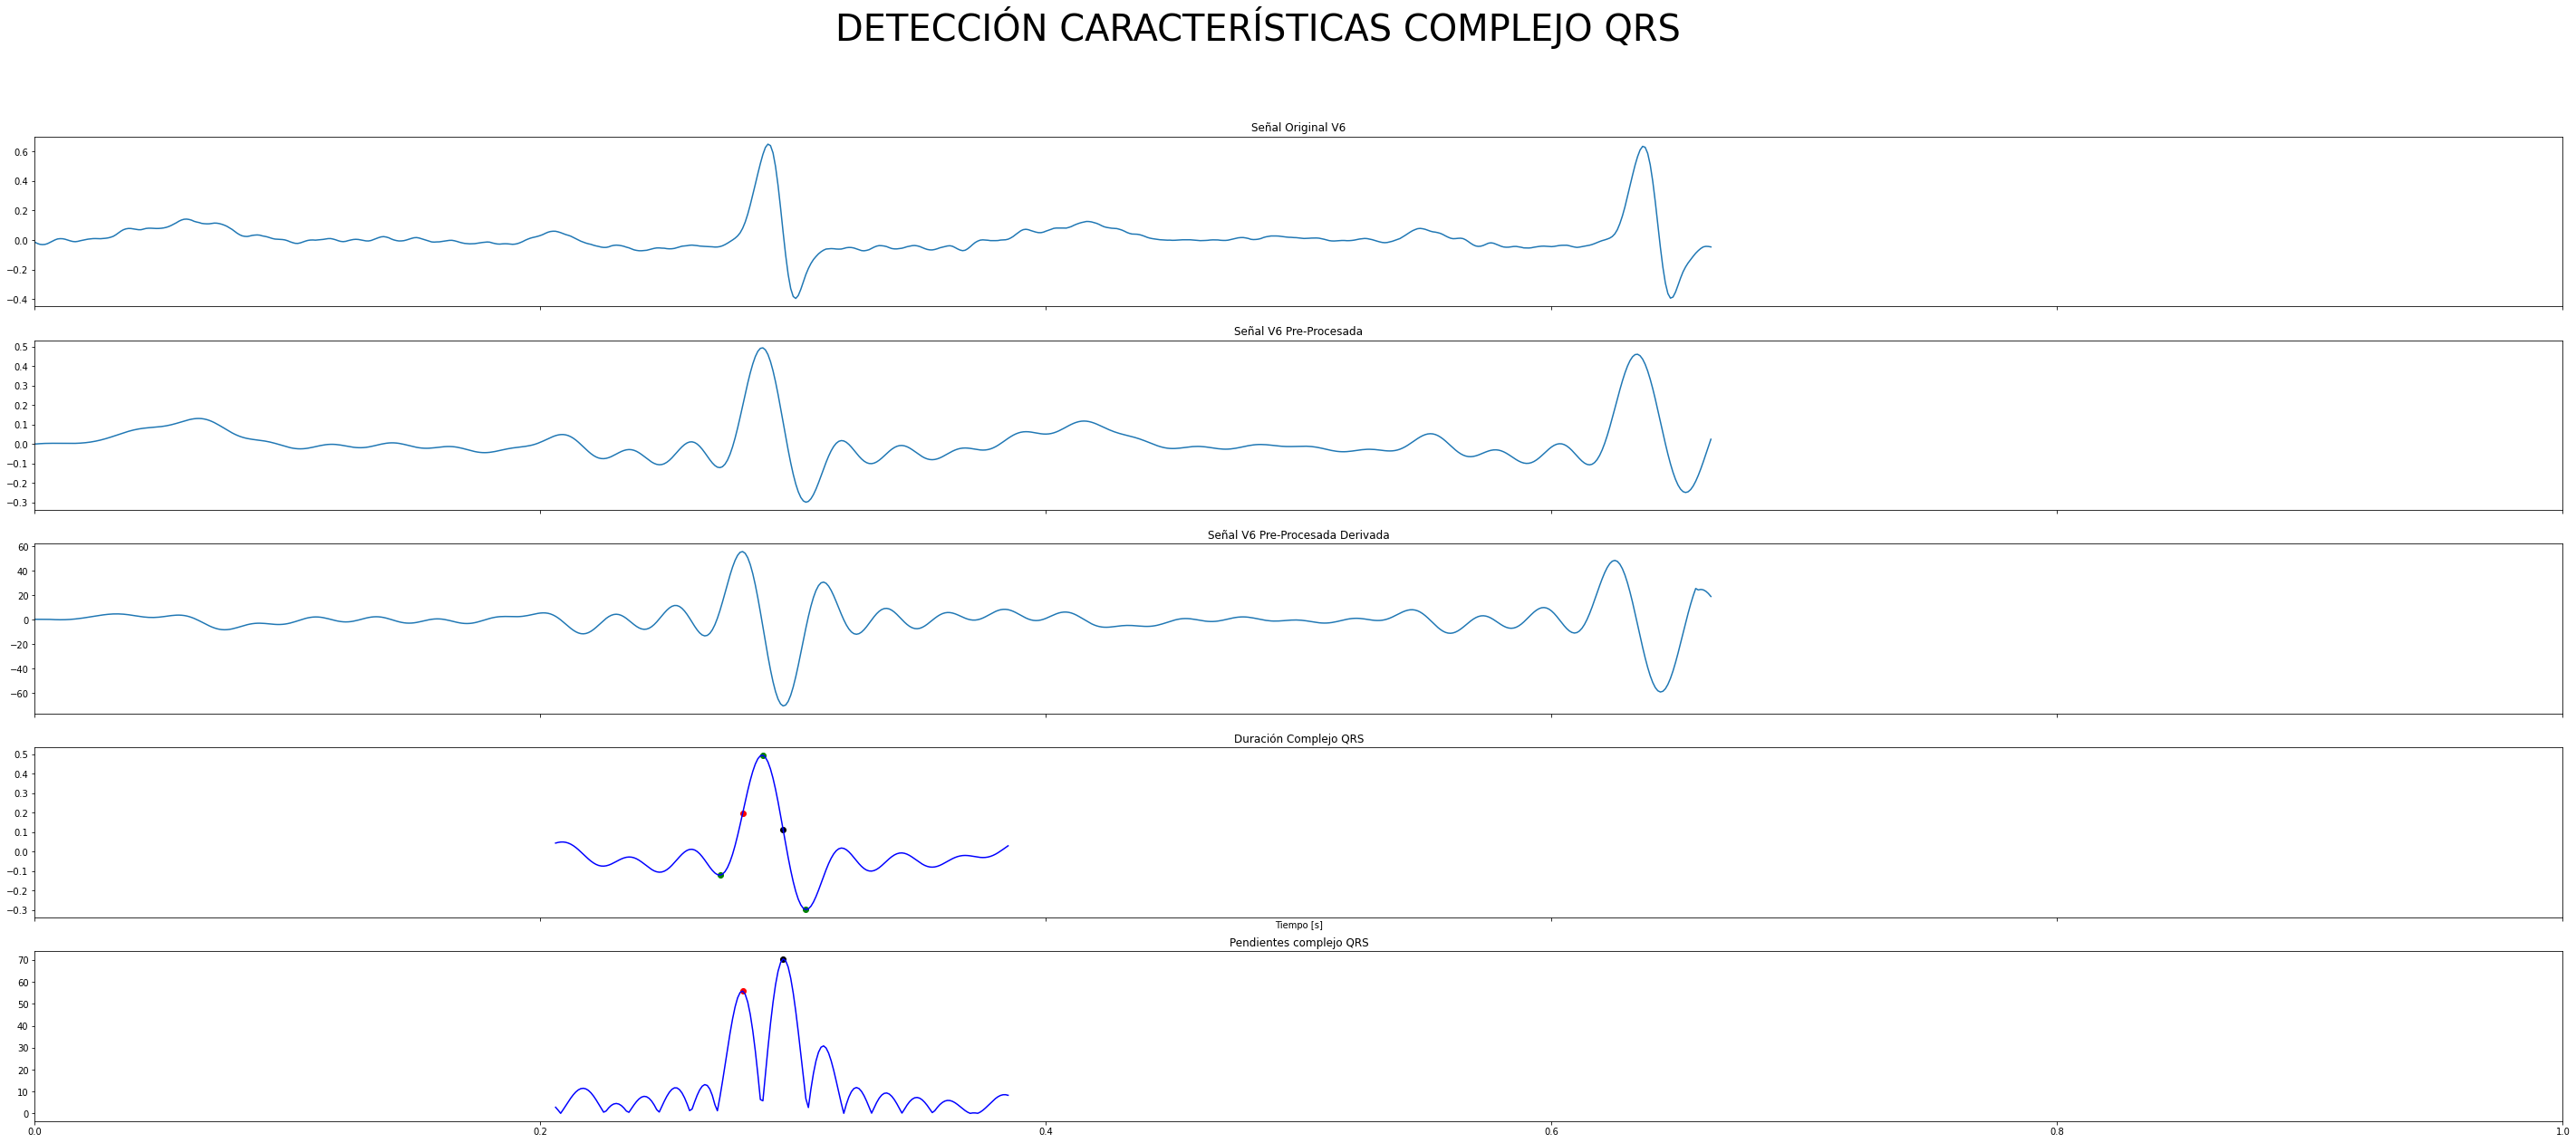

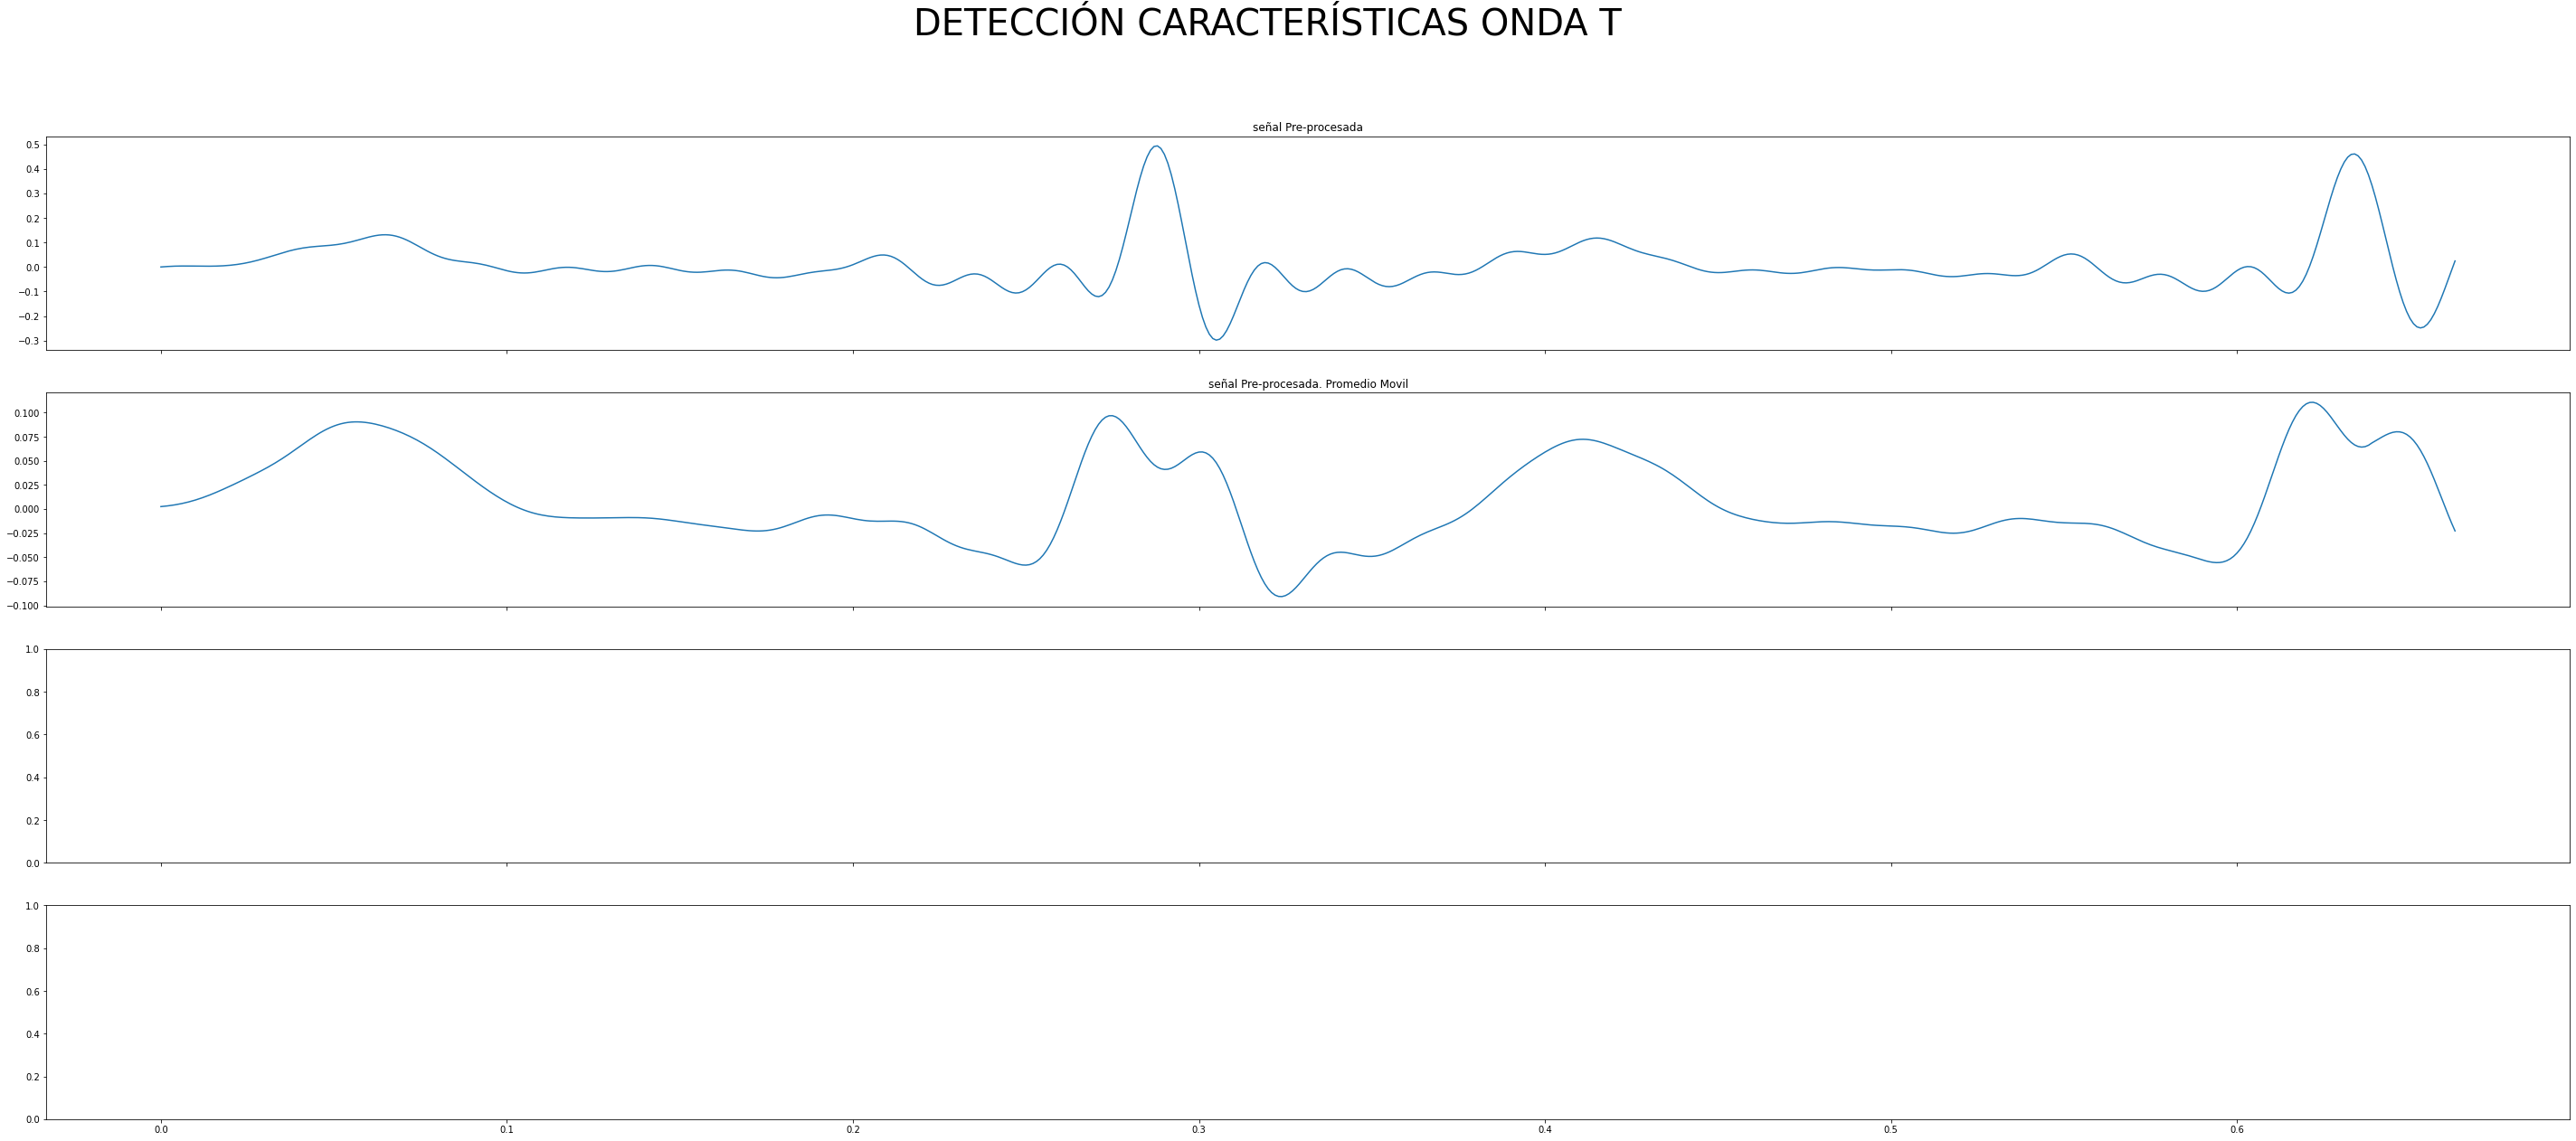

In [ ]:
res = qrst_caract(4,1,[0,1])

In [ ]:
res

[-0.12085029962064478,
 55.77201421862399,
 0.49356217192744,
 70.41188347326539,
 -0.29808755189958475,
 nan,
 nan,
 nan]

##### Detección características complejo QRS

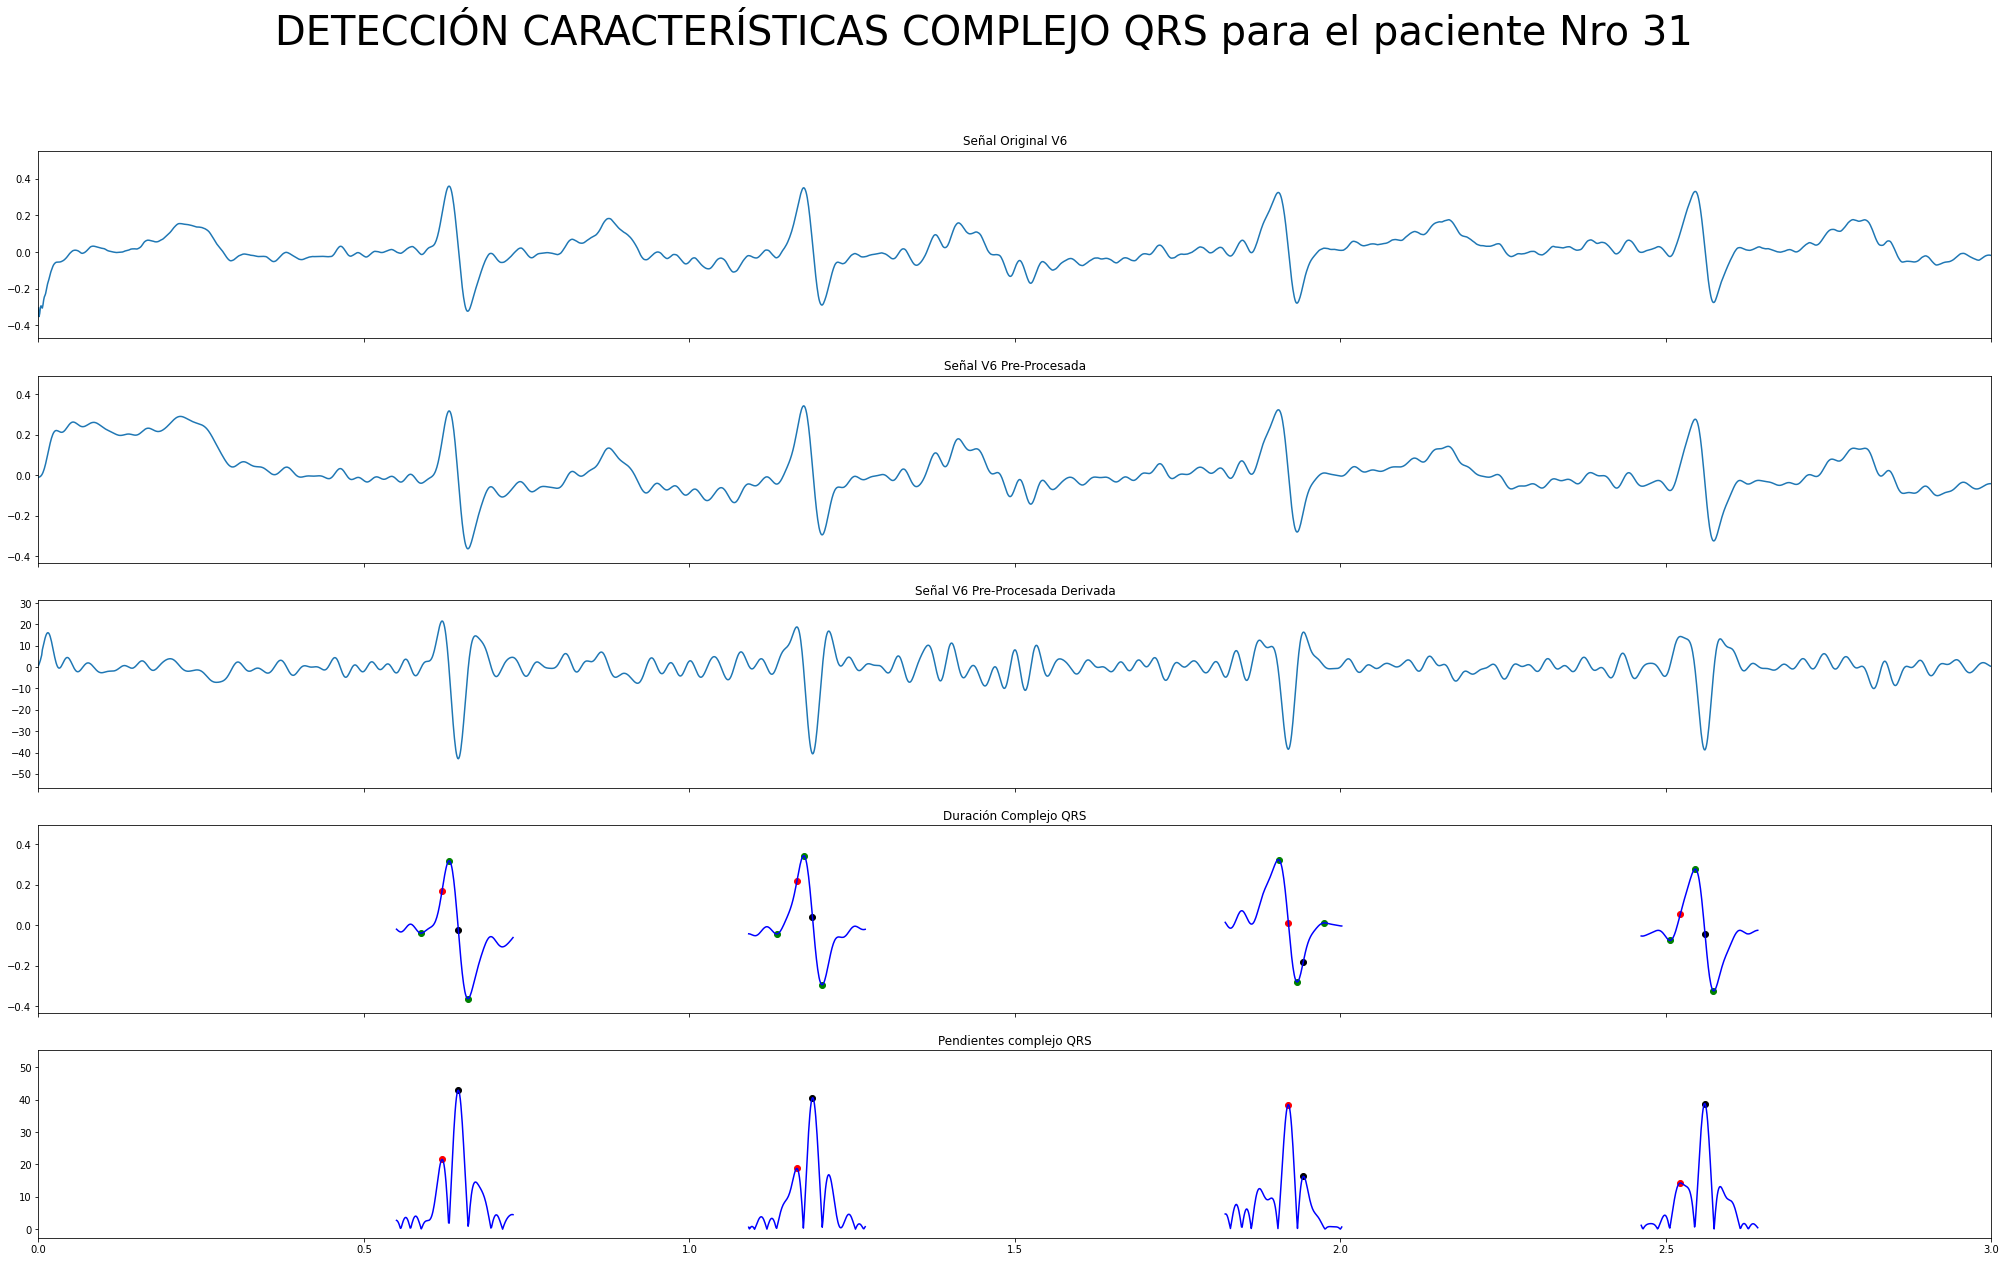

In [ ]:
nro_pac = 31
[t,s,qrs] = deteccion_qrs(nro_pac,'DII',0,[0,1])
filt = pre_procesamiento(nro_pac,'V6',0,[0,1],[0,50])

fs=1000
sf = 5
bD = derivarivo_filtro(sf,fs)
filtradaD = np.convolve(filt, bD, 'same')
fig1, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1,figsize=(35,20),sharex=True)
fig1.suptitle('DETECCIÓN CARACTERÍSTICAS COMPLEJO QRS para el paciente Nro '+ str(nro_pac),fontsize=40)
ax2.plot(t,filt)
ax2.set_title('Señal V6 Pre-Procesada')
ax3.plot(t,filtradaD)
ax3.set_title('Señal V6 Pre-Procesada Derivada')
ax1.plot(t,v6[nro_pac])
ax1.set_title('Señal Original V6')
plt.xlim([0,3])


dur_qrs = 0.18 #duracion es entre 80 y 120 ms. Como los qrs estas corridos, tomamos una duracion alta
intervalo = int(fs*dur_qrs/2)

for j in range(0,len(qrs)):
  if j == 0:
    if qrs[0]-intervalo >= 0:
      lim_inf = qrs[j]-intervalo
      lim_sup = qrs[j]+intervalo
    else:
      lim_inf = 0
      lim_sup = qrs[j]+intervalo
  elif j == len(qrs)-1:
    if qrs[len(qrs)-1]+intervalo < len(filtradaD):
      lim_inf = qrs[j]-intervalo
      lim_sup = qrs[j]+intervalo 
    else:
      lim_inf = qrs[j]-intervalo
      lim_sup = (len(filtradaD)-1)     
  else:
    lim_inf = qrs[j]-intervalo
    lim_sup = qrs[j]+intervalo
  
  der_cortada = np.abs(filtradaD[lim_inf:lim_sup])
  der_cortada_picos = signal.find_peaks(der_cortada)

  der_cortada_picos = der_cortada_picos[0]
  ax5.plot(t[lim_inf:lim_sup],der_cortada,c='blue')

  pico1 = np.sort(der_cortada[der_cortada_picos])[::-1][0]
  pico2 = np.sort(der_cortada[der_cortada_picos])[::-1][1]
  pico3 = np.sort(der_cortada[der_cortada_picos])[::-1][2]
  pico4 = np.sort(der_cortada[der_cortada_picos])[::-1][3]

  pico1_index = np.where(der_cortada == pico1)
  pico2_index = np.where(der_cortada == pico2)

  index_crec = np.sort([pico1_index[0][0],pico2_index[0][0]])

  penS_R = der_cortada[index_crec[0]]
  penB_R = der_cortada[index_crec[1]]

  qrs1 = filt[lim_inf:lim_sup]
  qrs1_picos = signal.find_peaks(np.abs(qrs1))

  r_amp = signal.find_peaks(np.abs(qrs1[index_crec[0]:index_crec[1]]))

  rt_dur = 0.07 #100 a 120 ms
  rt_intervalo = int(rt_dur*fs)
  pr_dur = 0.03 #50 a 120 ms
  pr_intervalo = int(pr_dur*fs)

  if len(r_amp[0])>1:
    r_amp = r_amp[0][int(np.round(len(r_amp[0])/2))]
    r_amp =qrs1[index_crec[0]:index_crec[1]][r_amp]
    ax4.scatter(t[lim_inf:lim_sup][np.where(qrs1 == r_amp)[0][0]],r_amp,c='green')
  elif len(r_amp[0]) == 0:
    r_amp = 0
  else:
    r_amp = r_amp[0][0]
    r_amp = qrs1[index_crec[0]:index_crec[1]][r_amp]
    ax4.scatter(t[lim_inf:lim_sup][np.where(qrs1 == r_amp)[0][0]],r_amp,c='green')

  if r_amp!=0:
    r_amp_idx_qrs1 = np.where(qrs1==r_amp)[0][0]
    pr_signal = qrs1[0:r_amp_idx_qrs1]
    rt_signal = qrs1[r_amp_idx_qrs1:len(qrs1)]
    #pr_signal = qrs1[r_amp_idx_qrs1-pr_intervalo:r_amp_idx_qrs1]
    if len(signal.find_peaks(np.abs(pr_signal))[0]) !=0:
      pr_signal_idx = np.sort(signal.find_peaks(np.abs(pr_signal))[0])[::-1][0]
      q_amp = pr_signal[pr_signal_idx]
      ax4.scatter(t[lim_inf:lim_sup][0:r_amp_idx_qrs1][pr_signal_idx],q_amp,c='green')
      #ax4.scatter(t[lim_inf:lim_sup][r_amp_idx_qrs1-pr_intervalo:r_amp_idx_qrs1][pr_signal_idx],q_amp,c='red')
      #rt_signal = qrs1[r_amp_idx_qrs1:r_amp_idx_qrs1+rt_intervalo]
    if len(signal.find_peaks(np.abs(rt_signal))[0]) !=0:
      rt_signal_idx = np.sort(signal.find_peaks(np.abs(rt_signal))[0])[0]
      s_amp = rt_signal[rt_signal_idx]
      ax4.scatter(t[lim_inf:lim_sup][r_amp_idx_qrs1:len(qrs1)][rt_signal_idx],s_amp,c='green')
      #ax4.scatter(t[lim_inf:lim_sup][r_amp_idx_qrs1:r_amp_idx_qrs1+rt_intervalo][rt_signal_idx],s_amp,c='red')


  ax4.plot(t[lim_inf:lim_sup],qrs1,c='blue')
  ax4.set_title('Duración Complejo QRS')

  ax5.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penS_R)],penS_R,c='red')
  ax5.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penB_R)],penB_R,c='black')
  #ax5.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penS_S)],penS_S,c='green')
  ax5.set_title('Pendientes complejo QRS')

  ax4.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penS_R)],qrs1[np.where(der_cortada == penS_R)],c='red')
  ax4.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penB_R)],qrs1[np.where(der_cortada == penB_R)],c='black')


##### Detección de características de la T

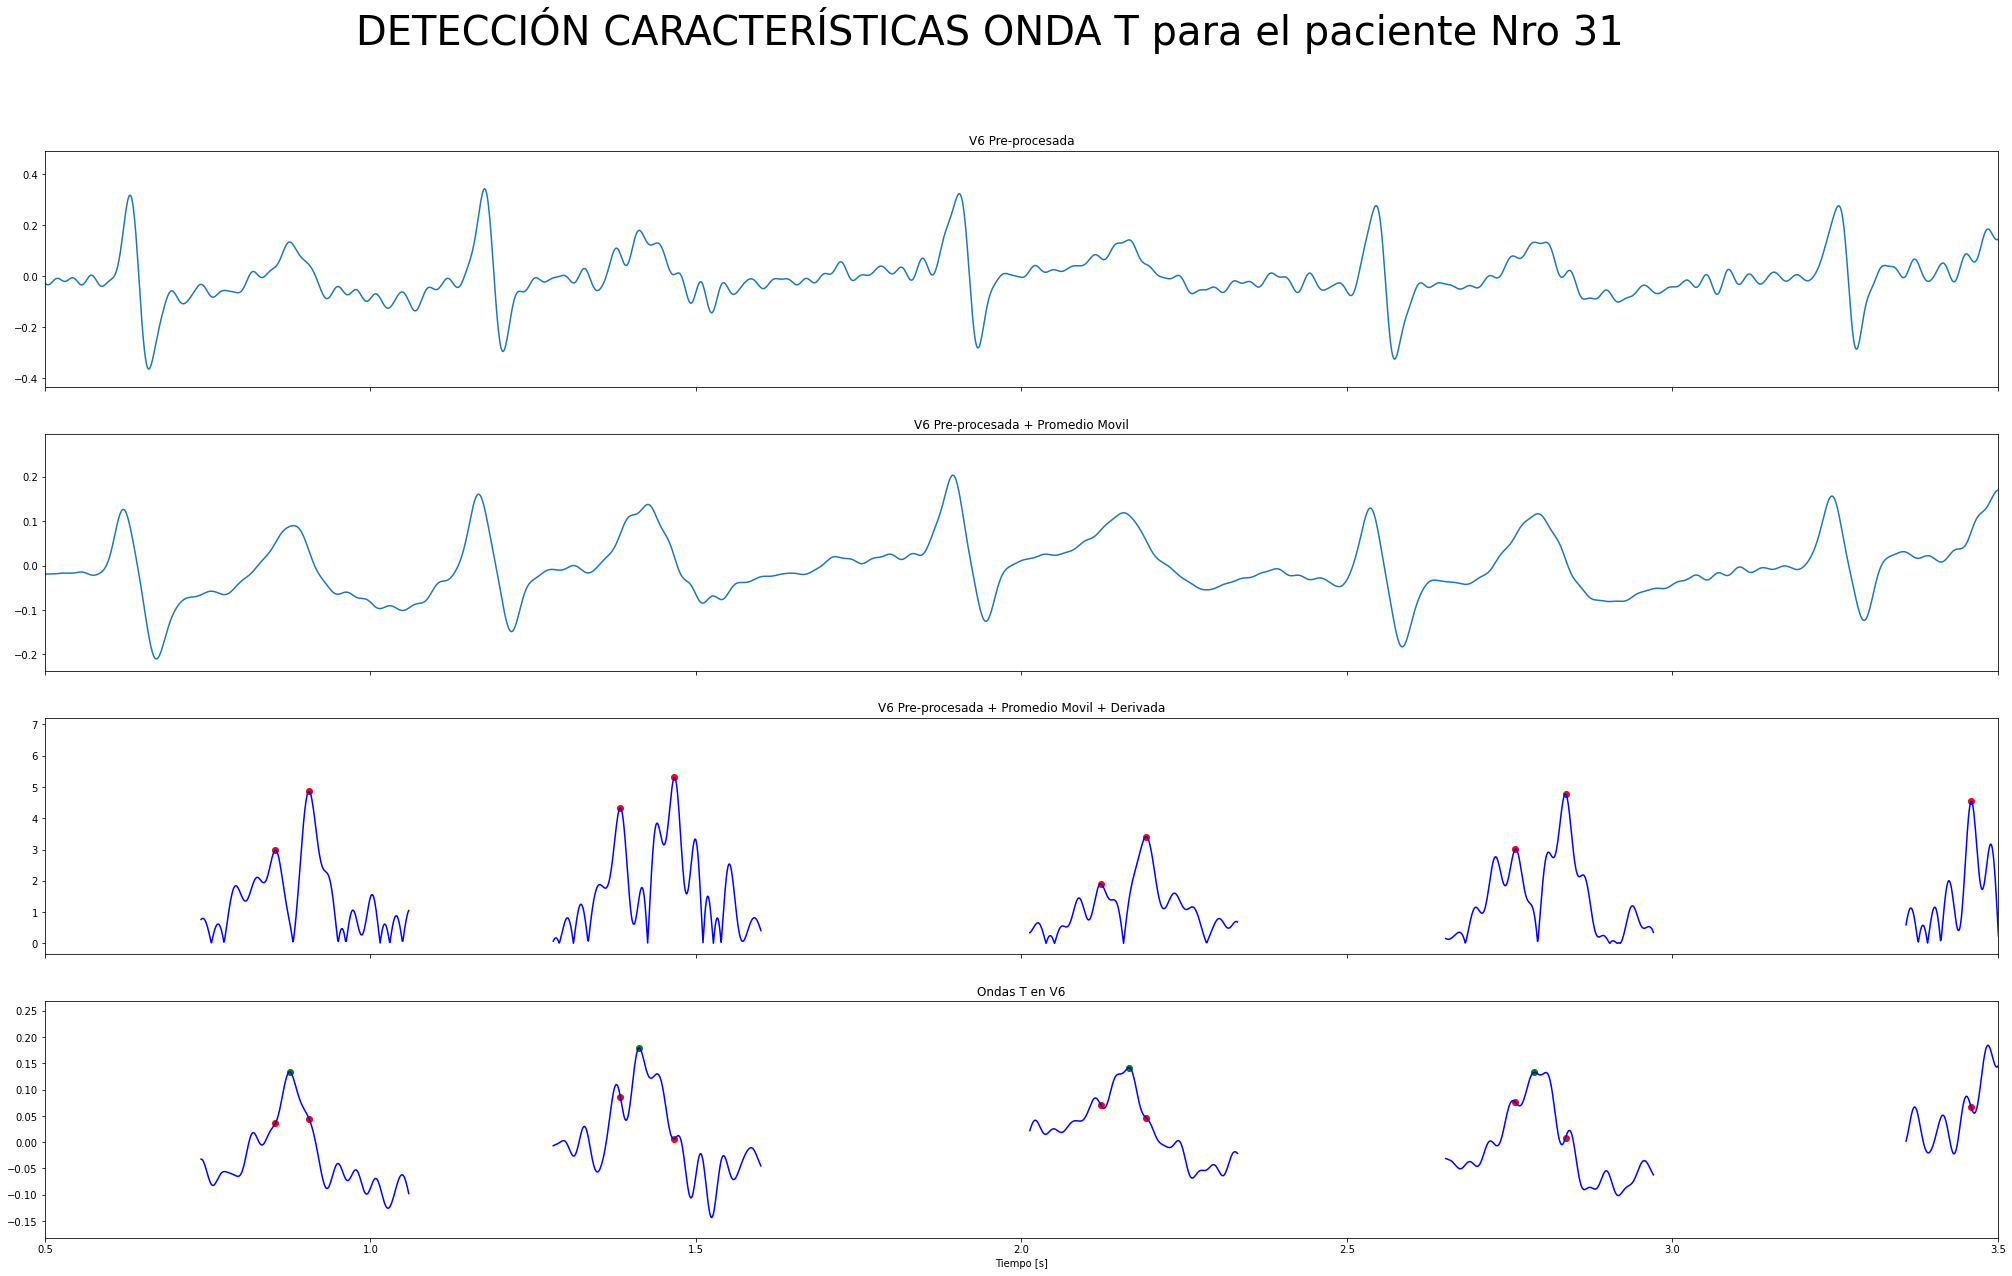

In [ ]:
nro_pac = 31

[t,s,qrs] = deteccion_qrs(nro_pac,'DII',0,[0,1])
filt = pre_procesamiento(nro_pac,'V6',0,[0,1],[0,50])
fs=1000

t_dur = 0.32 #st interval 320 ms + 50 ms
r_dur = 0.1
t_intervalo = int(t_dur*fs)
r_intervalo = int(r_dur*fs)

sf_T = 5
t_bD = derivarivo_filtro(sf_T,fs)
b,a = promedio_movil(50)
filt_prom = np.convolve(b,filt,'same')
filtD = np.convolve(filt_prom, t_bD, 'same')


fig2, (ax1_2,ax2a_2,ax2_2,ax3_2) = plt.subplots(4,1,figsize=(35,20),sharex=True)
fig2.suptitle('DETECCIÓN CARACTERÍSTICAS ONDA T para el paciente Nro '+str(nro_pac) ,fontsize=40)

ax1_2.plot(t,filt)
ax1_2.set_title('V6 Pre-procesada')
ax2a_2.plot(t,filt_prom)
ax2a_2.set_title('V6 Pre-procesada + Promedio Movil')
for j in range(0,len(qrs)):
  if qrs[j]+t_intervalo+r_intervalo < len(filt)-1:
    t_signal = filt[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo]
    #t_signal_D = filt_prom[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo]
    t_signal_D = np.abs(filtD[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo])

    ax3_2.plot(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo],t_signal,c='blue')
    ax3_2.set_title('Ondas T en V6')
    
    t_picos_idx = signal.find_peaks(np.abs(t_signal))[0]
    t_amp = np.sort(t_signal[t_picos_idx])[::-1][0]
    t_amp_idx = np.where(t_signal == t_amp)[0]
    ax3_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][t_amp_idx],t_amp,c='green')
    ax2_2.plot(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo],t_signal_D,c='blue')
    ax2_2.set_title('V6 Pre-procesada + Promedio Movil + Derivada')

    t_D_idx = signal.find_peaks(t_signal_D)[0]
    pen1 = np.sort(t_signal_D[t_D_idx])[::-1][0]
    pen2 = np.sort(t_signal_D[t_D_idx])[::-1][1]

    pen1_index = np.where(t_signal_D == pen1)
    pen2_index = np.where(t_signal_D == pen2)
    
    index_crec_T = np.sort([pen1_index[0][0],pen2_index[0][0]])

    penS_T = t_signal_D[index_crec_T[0]]
    penB_T = t_signal_D[index_crec_T[1]]

    ax2_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][index_crec_T[0]],penS_T,c='red')
    ax2_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][index_crec_T[1]],penB_T,c='red')

    ax3_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][index_crec_T[0]],t_signal[index_crec_T[0]],c='red')
    ax3_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][index_crec_T[1]],t_signal[index_crec_T[1]],c='red')

    ax3_2.set_xlabel('Tiempo [s]')
    plt.xlim([0.5,3.5])
  

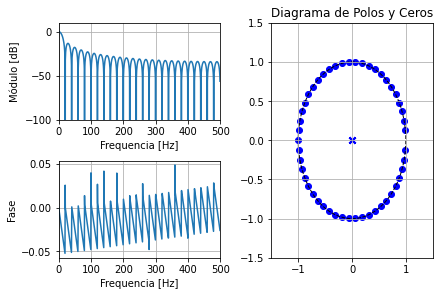

In [ ]:
b,a = promedio_movil(50)
graficar_rtaFiltos(b,a,1000,[0,500],[-100,10])

##### DETECCIÓN CARACTERÍSTICAS QRST CON HRV

In [ ]:
def qrst_hrv_caract(nro_pac,graficar,lim_tiempo):
  [t,s,qrs] = deteccion_qrs(nro_pac,'DII',0,[0,1])
  filt = pre_procesamiento(nro_pac,'V6',0,[0,1],[0,100])
  fs = fm[nro_pac]

  #filtro derivador
  sf = 5
  bD = derivarivo_filtro(sf,fs)

  filtradaD = np.convolve(filt, bD, 'same')

  if graficar==1:
    fig1, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1,figsize=(50,20),sharex=True)
    fig1.suptitle('DETECCIÓN CARACTERÍSTICAS COMPLEJO QRS',fontsize=40)
    ax2.plot(t,filt)
    ax2.set_title('Señal V6 Pre-Procesada')
    ax3.plot(t,filtradaD)
    ax3.set_title('Señal V6 Pre-Procesada Derivada')
    ax1.plot(t,v6[nro_pac])
    ax1.set_title('Señal Original V6')
    plt.xlim(lim_tiempo)
    

  dur_qrs = 0.18 #duracion es entre 80 y 120 ms. Como los qrs estas corridos, tomamos una duracion alta
  intervalo = int(fs*dur_qrs/2)

  r_amp_lista = []
  penS_R_lista = []
  penB_R_lista = []
  q_amp_lista = []
  s_amp_lista = []

  t_dur = 0.32 #st interval 320 ms + 50 ms
  r_dur = 0.1
  t_intervalo = int(t_dur*fs)
  r_intervalo = int(r_dur*fs)

  sf_T = 30
  t_bD = derivarivo_filtro(sf_T,fs)
  b,a = promedio_movil(50)
  filt_prom = np.convolve(b,filt,'same')
  filtD = np.convolve(filt_prom, t_bD, 'same')

  if graficar ==1:
    fig2, (ax1_2,ax2a_2,ax2_2,ax3_2) = plt.subplots(4,1,figsize=(50,20),sharex=True)
    fig2.suptitle('DETECCIÓN CARACTERÍSTICAS ONDA T',fontsize=40)
    ax1_2.plot(t,filt)
    ax1_2.set_title('señal Pre-procesada')
    ax2a_2.plot(t,filt_prom)
    ax2a_2.set_title('señal Pre-procesada. Promedio Movil')

  penS_T_lista = []
  t_amp_lista=[]
  penB_T_lista = []

  for j in range(0,len(qrs)):
    if j == 0:
      if qrs[0]-intervalo >= 0:
        lim_inf = qrs[j]-intervalo
        lim_sup = qrs[j]+intervalo
      else:
        lim_inf = 0
        lim_sup = qrs[j]+intervalo
    elif j == len(qrs)-1:
      if qrs[len(qrs)-1]+intervalo < len(filtradaD):
        lim_inf = qrs[j]-intervalo
        lim_sup = qrs[j]+intervalo 
      else:
        lim_inf = qrs[j]-intervalo
        lim_sup = (len(filtradaD)-1)     
    else:
      lim_inf = qrs[j]-intervalo
      lim_sup = qrs[j]+intervalo
    
    der_cortada = np.abs(filtradaD[lim_inf:lim_sup])
    der_cortada_picos = signal.find_peaks(der_cortada)

    der_cortada_picos = der_cortada_picos[0]
    

    pico1 = np.sort(der_cortada[der_cortada_picos])[::-1][0]
    pico2 = np.sort(der_cortada[der_cortada_picos])[::-1][1]
    pico3 = np.sort(der_cortada[der_cortada_picos])[::-1][2]
    pico4 = np.sort(der_cortada[der_cortada_picos])[::-1][3]

    pico1_index = np.where(der_cortada == pico1)
    pico2_index = np.where(der_cortada == pico2)

    index_crec = np.sort([pico1_index[0][0],pico2_index[0][0]])

    penS_R = der_cortada[index_crec[0]]
    penB_R = der_cortada[index_crec[1]]

    penS_R_lista.append(penS_R)
    penB_R_lista.append(penB_R)

    qrs1 = filt[lim_inf:lim_sup]
    qrs1_picos = signal.find_peaks(np.abs(qrs1))

    r_amp = signal.find_peaks(np.abs(qrs1[index_crec[0]:index_crec[1]]))

    if len(r_amp[0])>1:
      r_amp = r_amp[0][int(np.round(len(r_amp[0])/2))]
      r_amp =qrs1[index_crec[0]:index_crec[1]][r_amp]
      r_amp_lista.append(r_amp)
      if graficar ==1:
        ax4.scatter(t[lim_inf:lim_sup][np.where(qrs1 == r_amp)[0][0]],r_amp,c='green')
    elif len(r_amp[0]) == 0:
      r_amp = 0
    else:
      r_amp = r_amp[0][0]
      r_amp = qrs1[index_crec[0]:index_crec[1]][r_amp]
      r_amp_lista.append(r_amp)
      if graficar ==1:
        ax4.scatter(t[lim_inf:lim_sup][np.where(qrs1 == r_amp)[0][0]],r_amp,c='green')

    if r_amp!=0:
      r_amp_idx_qrs1 = np.where(qrs1==r_amp)[0][0]
      pr_signal = qrs1[0:r_amp_idx_qrs1]
      rt_signal = qrs1[r_amp_idx_qrs1:len(qrs1)]
      #pr_signal = qrs1[r_amp_idx_qrs1-pr_intervalo:r_amp_idx_qrs1]
      if len(signal.find_peaks(np.abs(pr_signal))[0]) !=0:
        pr_signal_idx = np.sort(signal.find_peaks(np.abs(pr_signal))[0])[::-1][0]
        q_amp = pr_signal[pr_signal_idx]
        q_amp_lista.append(q_amp)
        if graficar ==1:
          ax4.scatter(t[lim_inf:lim_sup][0:r_amp_idx_qrs1][pr_signal_idx],q_amp,c='green')
          #ax4.scatter(t[lim_inf:lim_sup][r_amp_idx_qrs1-pr_intervalo:r_amp_idx_qrs1][pr_signal_idx],q_amp,c='red')
          #rt_signal = qrs1[r_amp_idx_qrs1:r_amp_idx_qrs1+rt_intervalo]
      if len(signal.find_peaks(np.abs(rt_signal))[0]) !=0:
        rt_signal_idx = np.sort(signal.find_peaks(np.abs(rt_signal))[0])[0]
        s_amp = rt_signal[rt_signal_idx]
        s_amp_lista.append(s_amp)
        if graficar == 1:
          ax4.scatter(t[lim_inf:lim_sup][r_amp_idx_qrs1:len(qrs1)][rt_signal_idx],s_amp,c='green')
          #ax4.scatter(t[lim_inf:lim_sup][r_amp_idx_qrs1:r_amp_idx_qrs1+rt_intervalo][rt_signal_idx],s_amp,c='red')


    if graficar ==1:

      ax4.plot(t[lim_inf:lim_sup],qrs1,c='blue')
      ax4.set_title('Duración Complejo QRS')

      ax5.plot(t[lim_inf:lim_sup],der_cortada,c='blue')
      ax5.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penS_R)],penS_R,c='red')
      ax5.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penB_R)],penB_R,c='black')
      #ax5.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penS_S)],penS_S,c='green')
      ax5.set_title('Pendientes complejo QRS')

      ax4.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penS_R)],qrs1[np.where(der_cortada == penS_R)],c='red')
      ax4.scatter(t[lim_inf:lim_sup][np.where(der_cortada == penB_R)],qrs1[np.where(der_cortada == penB_R)],c='black')
      ax4.set_xlabel('Tiempo [s]')


    if qrs[j]+t_intervalo+r_intervalo < len(filt)-1:
      t_signal = filt[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo]
      #t_signal_D = filt_prom[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo]
      t_signal_D = np.abs(filtD[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo])
      t_picos_idx = signal.find_peaks(np.abs(t_signal))[0]
      t_amp = np.sort(t_signal[t_picos_idx])[::-1][0]
      t_amp_lista.append(t_amp)
      t_amp_idx = np.where(t_signal == t_amp)[0]
      
      if graficar ==1:
        ax3_2.plot(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo],t_signal,c='blue')
        ax3_2.set_title('Ondas T en V6')
        ax3_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][t_amp_idx],t_amp,c='green')
        ax2_2.plot(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo],t_signal_D,c='blue')
        ax2_2.set_title('Onda T Derivada en V6')

      t_D_idx = signal.find_peaks(t_signal_D)[0]
      pen1 = np.sort(t_signal_D[t_D_idx])[::-1][0]
      pen2 = np.sort(t_signal_D[t_D_idx])[::-1][1]

      pen1_index = np.where(t_signal_D == pen1)
      pen2_index = np.where(t_signal_D == pen2)
      
      index_crec_T = np.sort([pen1_index[0][0],pen2_index[0][0]])

      penS_T = t_signal_D[index_crec_T[0]]
      penB_T = t_signal_D[index_crec_T[1]]

      penS_T_lista.append(penS_T)
      penB_T_lista.append(penB_T)

      if graficar==1:
        ax2_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][index_crec_T[0]],penS_T,c='red')
        ax2_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][index_crec_T[1]],penB_T,c='red')
        ax3_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][index_crec_T[0]],t_signal[index_crec_T[0]],c='red')
        ax3_2.scatter(t[qrs[j]+r_intervalo:qrs[j]+t_intervalo+r_intervalo][index_crec_T[1]],t_signal[index_crec_T[1]],c='red')
        ax3_2.set_xlabel('Tiempo [s]')
        plt.xlim([0,10])
    
  var = hrv(fs,s,qrs)

  resultado = []
  resultado.append(np.sum(q_amp_lista)/len(q_amp_lista))
  resultado.append(np.sum(penS_R_lista)/len(penS_R_lista))
  resultado.append(np.sum(r_amp_lista)/len(r_amp_lista))
  resultado.append(np.sum(penB_R_lista)/len(penB_R_lista))
  resultado.append(np.sum(s_amp_lista)/len(s_amp_lista))
  resultado.append(np.sum(penS_T_lista)/len(penS_T_lista))
  resultado.append(np.sum(t_amp_lista)/len(t_amp_lista))
  resultado.append(np.sum(penB_T_lista)/len(penB_T_lista))
  resultado.append(var)

  return resultado

# MATRIZ DE CARACTERÍSTICAS

(nro_pac, q,sr,r,br,q,st,t,bt,clasif)

In [ ]:
def matrix_8_caract():
  col = 10 # una columna para kmeans
  fil = 45
  fs=1000

  matrix = np.ones((fil,col))

  for i in range(0,fil):
    res = qrst_caract(i,0,[0,10])
    matrix[i,1:9] = res
    matrix[i,0] = i 
  return matrix

In [ ]:
def matrix_9_caract():
  col = 11 #una columna para kmeans
  fil = 45
  fs=1000

  matrix = np.ones((fil,col))

  for i in range(0,fil):
      res = qrst_hrv_caract(i,0,[0,10])
      matrix[i,1:10] = res
      matrix[i,0] = i 
  return matrix

In [ ]:
m9 = matrix_9_caract()
m8 = matrix_8_caract()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:202: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:204: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in double_scalars


###### PROBLEMA CON LA MEDICIÓN DE LAS CARACTERISTICAS T para el paciente 4

In [ ]:
#ELIMINAMOS LOS PACIENTES CON PUNTOS FIDUCIALES MENORES QUE 10

m8_sin4 = np.delete(m8, (2,3,4,7,19), axis=0)
m9_sin4 = np.delete(m9, (2,3,4,7,19), axis=0)



# K-MEANS

In [ ]:
#pongo K =2 y inicialización de los clusters aleatoriamente.
m8_sin4_carac = m8_sin4[:,1:9]
m9_sin4_carac = m9_sin4[:,1:10]

KM9 = KMeans(n_clusters=2,init='random',max_iter=500,tol=1e-4).fit(m9_sin4_carac)

KM8 = KMeans(n_clusters=2,init='random',max_iter=500,tol=1e-4).fit(m8_sin4_carac)

m8_sin4[:,9] = KM8.labels_[0:44]
m9_sin4[:,10] = KM9.labels_[0:44]

In [ ]:
print('ETIQUETAS USANDO 8 ATRIBUTOS')
print(KM8.labels_)
print('ETIQUETAS USANDO 9 ATRIBUTOS')
print(KM9.labels_)

if (KM8.labels_ == KM9.labels_).all() or (KM8.labels_ == np.logical_not(KM9.labels_)).all():
  print('MISMA CLASIFICACIÓN')

ETIQUETAS USANDO 8 ATRIBUTOS
[0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1
 1 1 0]
ETIQUETAS USANDO 9 ATRIBUTOS
[0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1
 1 1 0]
MISMA CLASIFICACIÓN


In [ ]:
print('Clasificacion Kmeans')
print(m9_sin4[:,m9_sin4.shape[1]-1])
l = []
for i in m9_sin4[:,0]:
  print(i)
  l.append(labels[int(i)])
print('Clasificacion Real')
print(l)
print(l == m9_sin4[:,m9_sin4.shape[1]-1])

Clasificacion Kmeans
[0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0.]
0.0
1.0
5.0
6.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
Clasificacion Real
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0]
[ True False False  True  True False  True  True  True  True False  True
 False  True  True  True  True False  True  True False False  True False
 False  True False  True  True False  True False False  True False False
  True False  True  True]


# GRAFICO DE BOXPLOT POR ATRIBUTO POR CLASE

In [ ]:
def graficar_boxplot_caract(matrix_clasif,atributo):
  [fil,col] = matrix_clasif.shape
  fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,sharey=True,figsize=(8,5))
  clase1 = matrix_clasif[:,col-1] == 1
  clase2 = matrix_clasif[:,col-1] == 0
  ax1.boxplot(matrix_clasif[:,atributo][clase1])
  c1 = matrix_clasif[:,atributo][clase1]
  ax1.set_xlabel('Clase 1')
  ax2.boxplot(matrix_clasif[:,atributo][clase2])
  c2 = matrix_clasif[:,atributo][clase2]
  ax2.set_xlabel('Clase 2')
  if atributo == 1:
    fig.suptitle('Amplitud de Q', fontsize=15)
  if atributo == 2:
    fig.suptitle('Pendiente Subida R', fontsize=15)
  if atributo == 3:
    fig.suptitle('Amplitud de R', fontsize=15)
  if atributo == 4:
    fig.suptitle('Pendiente Bajada R', fontsize=15)
  if atributo == 5:
    fig.suptitle('Amplitud de S', fontsize=15)
  if atributo == 6:
    fig.suptitle('Pendiente de Subida de T', fontsize=15)
  if atributo == 7:
    fig.suptitle('Amplitud de T', fontsize=15)
  if atributo == 8:
    fig.suptitle('Pendiente de Bajada de T', fontsize=15)
  if atributo == 9:
    fig.suptitle('Variabildad HR', fontsize=15)

  rta = [c1,c2]

  return rta


[-0.10679332 -0.10624846 -0.02893138 -0.0470369  -0.05444741 -0.07004306
 -0.06696085 -0.0717659  -0.04294039  0.46372084 -0.13562372 -0.12084463
  0.1628924  -0.09073864 -0.15287902 -0.03952666 -0.10221397 -0.13616181
 -0.0806275  -0.08135514]


WilcoxonResult(statistic=83.0, pvalue=0.41146474044009396)

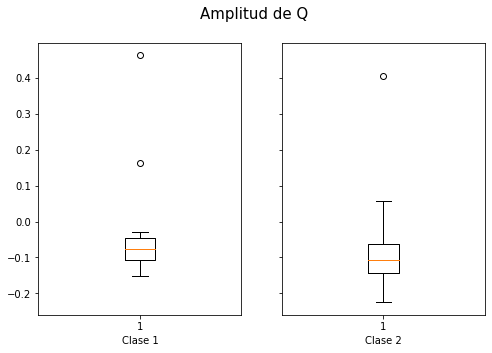

In [ ]:
  matrix_clasif = m9_sin4
  atributo = 1
  rta = graficar_boxplot_caract(matrix_clasif,atributo)
  print(rta[0])
  stats.wilcoxon(rta[0],rta[1])

# APRENDIZAJE SUPERVIZADO KNN

In [ ]:
#mezclo aleatoriamente las filas de la matriz de caracteristicas para
#separar 70% entrenamiento y 30% testeo

def div_matriz(matriz,porcentaje):
  filas = len(matriz)
  matriz_perm = np.random.permutation(matriz)
  matriz_entrenamiento = matriz_perm[0:int(np.round(porcentaje*filas)),:]
  matriz_testeo = matriz_perm[0:(filas-int(np.round(porcentaje*filas))),:]

  return matriz_entrenamiento,matriz_testeo

In [ ]:
def knn(matriz,graficar_matConfusion):
  porcentaje=0.7
  E,T = div_matriz(matriz,porcentaje)
  neigh = KNeighborsClassifier(n_neighbors=3)
  neigh.fit(E[:,1:matriz.shape[1]-2],E[:,matriz.shape[1]-2])
  vector_pred = neigh.predict(T[:,1:matriz.shape[1]-2])
  
  MATCONF = np.zeros((2,2))
  for i in range(0,T.shape[0]):
    real = T[i,matriz.shape[1]-1]
    estimado = vector_pred[i]
    if real == 0 and  estimado == 0:
      MATCONF[0,0] = MATCONF[0,0]+1
    if real == 0 and  estimado == 1:
      MATCONF[0,1] = MATCONF[0,1]+1
    if real == 1 and  estimado == 0:
      MATCONF[1,0] = MATCONF[1,0]+1
    if real == 1 and  estimado == 1:
      MATCONF[1,1] = MATCONF[1,1]+1
  if graficar_matConfusion == 1:
    print(MATCONF)
  return vector_pred,T,MATCONF


In [ ]:
def knn_labels(matriz,graficar_matConfusion):
  porcentaje=0.7
  E,T = div_matriz(matriz,porcentaje)
  neigh = KNeighborsClassifier(n_neighbors=3)
  neigh.fit(E[:,1:matriz.shape[1]-2],E[:,matriz.shape[1]-1])
  vector_pred = neigh.predict(T[:,1:matriz.shape[1]-2])
  
  MATCONF = np.zeros((2,2))
  for i in range(0,T.shape[0]):
    real = T[i,matriz.shape[1]-1]
    estimado = vector_pred[i]
    if real == 0 and  estimado == 0:
      MATCONF[0,0] = MATCONF[0,0]+1
    if real == 0 and  estimado == 1:
      MATCONF[0,1] = MATCONF[0,1]+1
    if real == 1 and  estimado == 0:
      MATCONF[1,0] = MATCONF[1,0]+1
    if real == 1 and  estimado == 1:
      MATCONF[1,1] = MATCONF[1,1]+1
  if graficar_matConfusion == 1:
    print(MATCONF)
  return vector_pred,T,MATCONF

In [ ]:
labels_copia = labels
labels_copia = np.delete(labels_copia,(2,3,4,7,19),axis=0)
matriz_labels = np.ones((m9_sin4.shape[0],m9_sin4.shape[1]+1)) 
matriz_labels[:,0:m9_sin4.shape[1]-1] = m9_sin4[:,0:m9_sin4.shape[1]-1]
matriz_labels[:,matriz_labels.shape[1]-1] = labels_copia

In [ ]:
vector_pred,T,MATCONF = knn(matriz_labels,1)

[[0. 5.]
 [0. 7.]]


In [ ]:
col = test_matriz.shape[1]
print('Predicción con KNN')
print(prediccion)
print('Cluster KMEANS')
print(test_matriz[:,col-1])
print('Numero de paciente')
print(test_matriz[:,0])

Predicción con KNN
[1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0.]
Cluster KMEANS
[0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0.]
Numero de paciente
[24. 34. 11. 15. 43. 23. 33. 37. 27. 44. 29.  1.]
